In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
# Remember that wcword is different from word or token in usual sense! 
!man wc|grep -A 2 -B 1 "A word is"


     A word is defined as a string of characters delimited by white space
     characters.  White space characters are the set of characters for which
     the iswspace(3) function returns true.  If more than one input file is


# Load data

In [4]:

def load_lang_stat(stats_dir):
    df = pd.read_csv(Path(stats_dir)/'stats.tsv', sep='\t').drop(columns='text_bytes')
    df['crawl'] = str(stats_dir)
    return df

def add_total(df):
    total = df.sum(numeric_only=True, axis=0).to_frame().T
    total.loc[:,'lang'] = 'TOTAL'
    total.loc[:,'crawl'] = next(iter(df['crawl'].unique()))
    df = pd.concat([total,df], ignore_index=True)
    return df

ldfs = {d.name: add_total(load_lang_stat(d)) 
                 for d in Path('.').glob('release2.0_dedup*stats') if d.is_dir()}
print(', '.join(ldfs.keys()))
next(iter(ldfs.values()))

release2.0_dedup_stats


text_newlines   text_wcwords      text_chars         docs      lang  \
0     613308414835  7581053828821  52004660650575  20620090001     TOTAL   
1           825077        3348713        25689522        11667  ace_Arab   
2         44949744      172750790      1585989859      1257535  ace_Latn   
3        251519794     2425634067     18352201435      9589394  afr_Latn   
4        304294712     4372079575     28416802362     11291570  als_Latn   
..             ...            ...             ...          ...       ...   
189      131064015      235766941      2266049229      3772042  yue_Hant   
190    76745471229   149309615501   3665438918192   2713235166  zho_Hans   
191     7818212137    17313596242    417513998557    321270354  zho_Hant   
192     3106520966    28661990213    193523621046     69227648  zsm_Latn   
193       33141935      156417516      1325885077      1305320  zul_Latn   

                      crawl  
0    release2.0_dedup_stats  
1    release2.0_dedup_stats  
2    release2.0_dedup_stats  
3    release2.0_dedup_stats  
4    release2.0_dedup_stats  
..                      ...  
189  release2.0_dedup_stats  
190  release2.0_dedup_stats  
191  release2.0_dedup_stats  
192  release2.0_dedup_stats  
193  release2.0_dedup_stats  

[194 rows x 6 columns]

In [5]:
def load_lang_stat_mr(stats_dir):
    df = pd.read_csv(Path(stats_dir)/'stats.tsv', sep='\t', header=None, 
                     names=['index','text_newlines','text_wcwords','text_chars','docs'])
    df[['crawl','lang']] = df['index'].str.split(',', expand=True)
    df.drop(columns='index', inplace=True)
    return df


def rename_crawl(df, crawl):
    df.crawl = crawl
    return df

def agg_by_lang(df):
    return df.groupby('lang').sum().reset_index()

In [6]:
ldfs.update({d.name: rename_crawl(agg_by_lang(add_total(load_lang_stat_mr(d))), d.name)
                 for d in Path('.').glob('release[2-3]*stats_mr') if d.is_dir()})
print(', '.join([f'{k}:{len(v)}' for k,v in ldfs.items()]))

next(iter(ldfs.values()))

release2.0_dedup_stats:194, release2.0_html_stage2_stats_mr:195, release3.0_dedup_stats_mr:201, release3.0_html_stage2_stats_mr:202, release2.0_cleaned_stats_mr:192, release3.0_cleaned_stats_mr:199


text_newlines   text_wcwords      text_chars         docs      lang  \
0     613308414835  7581053828821  52004660650575  20620090001     TOTAL   
1           825077        3348713        25689522        11667  ace_Arab   
2         44949744      172750790      1585989859      1257535  ace_Latn   
3        251519794     2425634067     18352201435      9589394  afr_Latn   
4        304294712     4372079575     28416802362     11291570  als_Latn   
..             ...            ...             ...          ...       ...   
189      131064015      235766941      2266049229      3772042  yue_Hant   
190    76745471229   149309615501   3665438918192   2713235166  zho_Hans   
191     7818212137    17313596242    417513998557    321270354  zho_Hant   
192     3106520966    28661990213    193523621046     69227648  zsm_Latn   
193       33141935      156417516      1325885077      1305320  zul_Latn   

                      crawl  
0    release2.0_dedup_stats  
1    release2.0_dedup_stats  
2    release2.0_dedup_stats  
3    release2.0_dedup_stats  
4    release2.0_dedup_stats  
..                      ...  
189  release2.0_dedup_stats  
190  release2.0_dedup_stats  
191  release2.0_dedup_stats  
192  release2.0_dedup_stats  
193  release2.0_dedup_stats  

[194 rows x 6 columns]

In [7]:
ldfs = {k.replace('_stats','').replace('_mr','').replace('release',''):v for k,v in ldfs.items()}
ldfs = {k.replace('2.0','old').replace('3.0','new'):v for k,v in ldfs.items()}
for k,v in ldfs.items():
    print(k, v.crawl.unique())
    v.crawl = k
ldfs.keys()

old_dedup ['release2.0_dedup_stats']
old_html_stage2 ['release2.0_html_stage2_stats_mr']
new_dedup ['release3.0_dedup_stats_mr']
new_html_stage2 ['release3.0_html_stage2_stats_mr']
old_cleaned ['release2.0_cleaned_stats_mr']
new_cleaned ['release3.0_cleaned_stats_mr']


dict_keys(['old_dedup', 'old_html_stage2', 'new_dedup', 'new_html_stage2', 'old_cleaned', 'new_cleaned'])

In [8]:
nldf = pd.DataFrame.from_records([(k.split('_')[0], '_'.join(k.split('_')[1:]), len(v)) for k,v in ldfs.items()], 
                                 columns='release step n_langs'.split())
nldf.sort_values(by='step')

release         step  n_langs
4     old      cleaned      192
5     new      cleaned      199
0     old        dedup      194
2     new        dedup      201
1     old  html_stage2      195
3     new  html_stage2      202

In [9]:
outdir=Path('_release2vs3/')
outdir.mkdir(exist_ok=True, parents=True)
total_df = pd.concat([v[v.lang=='TOTAL'] for k,v in ldfs.items()], ignore_index=True).drop(columns='lang').set_index('crawl')
total_df *= 1.0
total_df.sort_values(by='crawl').to_csv(outdir/'TOTALs.tsv', float_format="%.2e", sep='\t')
!column -t $outdir/TOTALs.tsv

crawl            text_newlines  text_wcwords  text_chars  docs
new_cleaned      7.50e+11       1.73e+13      1.12e+14    2.95e+10
new_dedup        1.20e+12       1.99e+13      1.32e+14    4.81e+10
new_html_stage2  4.83e+12       6.03e+13      4.10e+14    2.13e+11
old_cleaned      3.00e+11       5.56e+12      3.74e+13    1.06e+10
old_dedup        6.13e+11       7.58e+12      5.20e+13    2.06e+10
old_html_stage2  2.22e+12       2.13e+13      1.46e+14    1.06e+11


#### Compare 3 crawls present in both v1 and v2: CC 2022-40, wide15, wide17

In [8]:


ldfs.update({'release1_' + d.name.split('_')[0]: rename_crawl(add_total(load_lang_stat_mr(d)), 'release1_' + d.name.split('_')[0])
                 for d in Path('.').glob('*filtered_stats_mr') if d.is_dir()})


qdf = load_lang_stat_mr('./release2.0_html_stage2_stats_mr/')

ldfs.update({'release2.0_'+c.replace('CC-MAIN-2022-40', 'cc40'): 
             rename_crawl(add_total(qdf[qdf.crawl==c].copy()), 'release2.0_'+c.replace('CC-MAIN-2022-40', 'cc40')) 
             for c in ('wide00015','wide00017','CC-MAIN-2022-40')})

crawl                 text_newlines  text_wcwords  text_chars  docs
new_cleaned           7.50e+11       1.73e+13      1.12e+14    2.95e+10
new_dedup             1.20e+12       1.99e+13      1.32e+14    4.81e+10
new_html_stage2       4.83e+12       6.03e+13      4.10e+14    2.13e+11
old_cleaned           3.00e+11       5.56e+12      3.74e+13    1.06e+10
old_dedup             6.13e+11       7.58e+12      5.20e+13    2.06e+10
old_html_stage2       2.22e+12       2.13e+13      1.46e+14    1.06e+11
release1_cc40         4.69e+11       2.46e+12      1.68e+13    2.81e+09
release1_wide00015    1.08e+12       4.90e+12      3.26e+13    5.12e+09
release1_wide00017    1.18e+12       4.70e+12      3.48e+13    1.04e+10
release2.0_cc40       6.48e+10       9.41e+11      6.76e+12    3.12e+09
release2.0_wide00015  1.39e+11       1.44e+12      9.93e+12    6.08e+09
release2.0_wide00017  1.42e+11       8.96e+11      7.61e+12    1.36e+10


# Load language mapping

In [10]:
# !git clone https://github.com/hplt-project/lang-id-fixes

In [11]:
ind2macro = pd.read_csv('lang-id-fixes/iso-639-3-macrolanguages.tab',sep='\t').set_index('I_Id')['M_Id'].to_dict()
"""Tagalog [tgl] is an Austronesian language spoken as a first
language by the ethnic Tagalog people, who make up a quarter of the population of the Philippines, and as a second language by the majority,
mostly as or through Filipino. Its de facto standardized and codified form, officially named Filipino [fil], is the national language of the 
Philippines, and is one of the nation's two official languages, alongside English."""
ind2macro['fil'] = 'tgl'

""" Kituba [ktu] (Kituba: Kituba, Kituba: Kikongo ya leta) is a widely used lingua franca in Central Africa. It is a creole language[3] based on 
Kikongo [kon], a Bantu language. It is a national language in Republic of the Congo and Democratic Republic of the Congo."""
ind2macro['ktu'] = 'kon'

ind2macro['zgh'] = 'tzm' # not alternative with the Tfng script


In [12]:
linf = pd.read_csv('./_langs/langs_HPLTv2.tsv', sep='\t')
linf

v2 Language Code (ISO 693-3+script)   Language Name ISO693-3 code  \
0                              ace_Arab        Achinese           ace   
1                              ace_Latn        Achinese           ace   
2                              afr_Latn       Afrikaans           afr   
3                              als_Latn   Tosk Albanian           als   
4                              amh_Ethi         Amharic           amh   
..                                  ...             ...           ...   
188                            yue_Hant     Yue Chinese           yue   
189                            zho_Hans         Chinese           zho   
190                            zho_Hant         Chinese           zho   
191                            zsm_Latn  Standard Malay           zsm   
192                            zul_Latn            Zulu           zul   

    ISO693-3 code macro ISO693-1 direct code ISO693-1 through macro  
0                   NaN                  NaN                    NaN  
1                   NaN                  NaN                    NaN  
2                   NaN                   af                     af  
3                   sqi                  NaN                     sq  
4                   NaN                   am                     am  
..                  ...                  ...                    ...  
188                 zho                  NaN                     zh  
189                 NaN                   zh                     zh  
190                 NaN                   zh                     zh  
191                 msa                  NaN                     ms  
192                 NaN                   zu                     zu  

[193 rows x 6 columns]

In [13]:
assert (linf['v2 Language Code (ISO 693-3+script)'].str.split('_').str[0]==linf['ISO693-3 code']).all()

In [14]:
langs = [set(ldfs[f'{v}_html_stage2'].lang.unique()) for v in 'old new'.split()]

In [15]:
for script in linf['v2 Language Code (ISO 693-3+script)'].str.split('_').str[1].unique():
    print(f'{script}:')
    for i in range(2):
        print('old: new:'.split()[i],' '.join((l+'/'+ind2macro.get(l.split('_')[0], '') for l in langs[i].difference(langs[1-i]) if l.endswith(script))))

Arab:
old: ara_Arab/
new: arb_Arab/ara acm_Arab/ara apc_Arab/ara acq_Arab/ara aeb_Arab/ara arz_Arab/ara ary_Arab/ara ars_Arab/ara
Latn:
old: grn_Latn/ est_Latn/ kon_Latn/ tgl_Latn/
new: ktu_Latn/kon gug_Latn/grn fil_Latn/tgl ekk_Latn/est
Ethi:
old: 
new: 
Beng:
old: 
new: 
Deva:
old: 
new: 
Cyrl:
old: 
new: 
Tibt:
old: 
new: 
Grek:
old: 
new: 
Gujr:
old: 
new: 
Hebr:
old: 
new: 
Armn:
old: 
new: 
Jpan:
old: 
new: 
Knda:
old: 
new: 
Geor:
old: 
new: 
Khmr:
old: 
new: 
Hang:
old: 
new: 
Laoo:
old: 
new: 
Mlym:
old: 
new: 
Mymr:
old: 
new: 
Orya:
old: 
new: 
Guru:
old: 
new: 
Olck:
old: 
new: 
Sinh:
old: 
new: 
Taml:
old: 
new: 
Tfng:
old: tzm_Tfng/
new: zgh_Tfng/tzm
Telu:
old: 
new: 
Thai:
old: 
new: 
Hant:
old: zho_Hant/
new: cmn_Hant/zho
Hans:
old: zho_Hans/
new: cmn_Hans/zho


In [16]:
def map_lang(l):
    ll = l.split('_')[0]
    if ll not in ind2macro:
        return l
    return ind2macro[ll] + '_' + l.split('_')[1]


new2old = {l: l if l in langs[0] else map_lang(l) for l in langs[1]}
new2old['TOTAL'] = 'TOTAL'
new2old

{'afr_Latn': 'afr_Latn',
 'kir_Cyrl': 'kir_Cyrl',
 'nld_Latn': 'nld_Latn',
 'awa_Deva': 'awa_Deva',
 'tha_Thai': 'tha_Thai',
 'eus_Latn': 'eus_Latn',
 'bod_Tibt': 'bod_Tibt',
 'ory_Orya': 'ory_Orya',
 'hin_Deva': 'hin_Deva',
 'lit_Latn': 'lit_Latn',
 'pbt_Arab': 'pbt_Arab',
 'mos_Latn': 'mos_Latn',
 'ace_Arab': 'ace_Arab',
 'pes_Arab': 'pes_Arab',
 'nya_Latn': 'nya_Latn',
 'swe_Latn': 'swe_Latn',
 'mri_Latn': 'mri_Latn',
 'oci_Latn': 'oci_Latn',
 'bul_Cyrl': 'bul_Cyrl',
 'acq_Arab': 'ara_Arab',
 'lij_Latn': 'lij_Latn',
 'run_Latn': 'run_Latn',
 'tuk_Latn': 'tuk_Latn',
 'hau_Latn': 'hau_Latn',
 'fij_Latn': 'fij_Latn',
 'srd_Latn': 'srd_Latn',
 'por_Latn': 'por_Latn',
 'nno_Latn': 'nno_Latn',
 'fra_Latn': 'fra_Latn',
 'ita_Latn': 'ita_Latn',
 'dyu_Latn': 'dyu_Latn',
 'bjn_Arab': 'bjn_Arab',
 'bjn_Latn': 'bjn_Latn',
 'mar_Deva': 'mar_Deva',
 'scn_Latn': 'scn_Latn',
 'ace_Latn': 'ace_Latn',
 'lim_Latn': 'lim_Latn',
 'pan_Guru': 'pan_Guru',
 'ars_Arab': 'ara_Arab',
 'cmn_Hans': 'zho_Hans',


# Display ratios for two versions

In [17]:
ldfs.keys()

dict_keys(['old_dedup', 'old_html_stage2', 'new_dedup', 'new_html_stage2', 'old_cleaned', 'new_cleaned'])

In [18]:
rdfs = {} # ratios
for k in ldfs.keys():
    for origin_k in ldfs.keys():
        if k==origin_k: continue
        ldf, oldf = ldfs[k].copy(), ldfs[origin_k].copy()
        
        if k.startswith('old') and origin_k.startswith('new'):
            continue
        elif k.startswith('new') and origin_k.startswith('old'):
            ldf['olang'] = ldf.lang.apply(lambda l: new2old.get(l)).dropna()        
        else:
            ldf['olang'] = ldf.lang
        
        print(k, origin_k)
        ldf = ldf.set_index('olang')
        oldf = oldf.set_index('lang')

        ldf = ldf[ldf.index.isin(oldf.index)]
        oldf = oldf[oldf.index.isin(ldf.index)]

        # duplicate lines for old langs corresponding for several new langs
        oldf = oldf.merge(ldf.lang, how='inner', left_index=True, right_index=True)  

        oldf.index = oldf.lang + '/' + oldf.index
        ldf.index = ldf.lang + '/' + ldf.index

        for c in ldf.columns:
            
            if pd.api.types.is_numeric_dtype(ldf[c]):  
                ldf[c] = ldf[c].astype(float)
                ldf.loc[:,c] = ldf[c] / oldf[c]
        ldf['rank'] = oldf['text_chars'].rank(ascending=False)

        ldf.crawl += '/' + oldf.crawl
        ldf = ldf.reset_index()
        rdfs[f'{k}/{origin_k}'] = ldf

old_dedup old_html_stage2
old_dedup old_cleaned
old_html_stage2 old_dedup
old_html_stage2 old_cleaned
new_dedup old_dedup
new_dedup old_html_stage2
new_dedup new_html_stage2
new_dedup old_cleaned
new_dedup new_cleaned
new_html_stage2 old_dedup
new_html_stage2 old_html_stage2
new_html_stage2 new_dedup
new_html_stage2 old_cleaned
new_html_stage2 new_cleaned
old_cleaned old_dedup
old_cleaned old_html_stage2
new_cleaned old_dedup
new_cleaned old_html_stage2
new_cleaned new_dedup
new_cleaned new_html_stage2
new_cleaned old_cleaned


In [19]:
{k: (len(v), v['index'].unique() if 'index' in v.columns else '') for k,v in rdfs.items()}

{'old_dedup/old_html_stage2': (194,
  array(['TOTAL/TOTAL', 'ace_Arab/ace_Arab', 'ace_Latn/ace_Latn',
         'afr_Latn/afr_Latn', 'als_Latn/als_Latn', 'amh_Ethi/amh_Ethi',
         'ara_Arab/ara_Arab', 'asm_Beng/asm_Beng', 'ast_Latn/ast_Latn',
         'awa_Deva/awa_Deva', 'ayr_Latn/ayr_Latn', 'azb_Arab/azb_Arab',
         'azj_Latn/azj_Latn', 'bak_Cyrl/bak_Cyrl', 'bam_Latn/bam_Latn',
         'ban_Latn/ban_Latn', 'bel_Cyrl/bel_Cyrl', 'bem_Latn/bem_Latn',
         'ben_Beng/ben_Beng', 'bho_Deva/bho_Deva', 'bjn_Arab/bjn_Arab',
         'bjn_Latn/bjn_Latn', 'bod_Tibt/bod_Tibt', 'bos_Latn/bos_Latn',
         'bug_Latn/bug_Latn', 'bul_Cyrl/bul_Cyrl', 'cat_Latn/cat_Latn',
         'ceb_Latn/ceb_Latn', 'ces_Latn/ces_Latn', 'cjk_Latn/cjk_Latn',
         'ckb_Arab/ckb_Arab', 'crh_Latn/crh_Latn', 'cym_Latn/cym_Latn',
         'dan_Latn/dan_Latn', 'deu_Latn/deu_Latn', 'dik_Latn/dik_Latn',
         'dyu_Latn/dyu_Latn', 'dzo_Tibt/dzo_Tibt', 'ell_Grek/ell_Grek',
         'eng_Latn/eng_Latn', 'epo

In [20]:
pdf = pd.concat([v for k,v in rdfs.items()], ignore_index=True)

pdf = pdf.melt(id_vars=['index','lang','crawl', 'rank'])

In [21]:
pdf.crawl = pdf.crawl.str.replace('release','').str.replace('_stats','')
ok = origin_k.replace('release','').replace('_stats','')

In [22]:
print(pdf.variable.unique())
pdf = pdf[pdf.variable.isin('docs text_newlines text_chars'.split())]

['text_newlines' 'text_wcwords' 'text_chars' 'docs']


In [23]:
pdf = pdf.sort_values(by=['variable','rank'])

In [24]:
import math
sns.set_style(style='whitegrid')

# TODO: logscale, add raw stats for 1.2_cleaned and sort by it
def plot_ratios(pdf, cats='index', vline=1, log_base=2, row_order=None, height=12, aspect=0.5, save_path=None):
    g = sns.catplot(data=pdf, legend=False,
                y=cats, hue=cats, x='value', row='crawl', col='variable', row_order=row_order,
                kind='bar', height=height, aspect=aspect,  palette='pastel',log=log_base, log_scale=(log_base>1))
    if log_base>1:
        b = int(np.ceil(math.log(pdf.value.max(), log_base)))
        a = int(np.floor(math.log(pdf.value.min(), log_base)))
        a = max(a, -5)
        plt.xticks([log_base**i for i in range(a,b)], labels=[f'1/{log_base**-i}' for i in range (a,0)] + 
                   [str(log_base**i) for i in range(0,b)] if a*b<0 else [f'${log_base}^{{{i}}}$' for i in range(a,b)])
    if vline is not None:
        for ax in g.axes.flatten():
            ax.axvline(vline)
    if save_path:
        g.savefig(save_path)

In [25]:
pdf.crawl.unique()


array(['old_dedup/old_html_stage2', 'old_dedup/old_cleaned',
       'old_html_stage2/old_dedup', 'old_html_stage2/old_cleaned',
       'new_dedup/old_dedup', 'new_dedup/old_html_stage2',
       'new_dedup/new_html_stage2', 'new_dedup/old_cleaned',
       'new_dedup/new_cleaned', 'new_html_stage2/old_dedup',
       'new_html_stage2/old_html_stage2', 'new_html_stage2/new_dedup',
       'new_html_stage2/old_cleaned', 'new_html_stage2/new_cleaned',
       'old_cleaned/old_dedup', 'old_cleaned/old_html_stage2',
       'new_cleaned/old_dedup', 'new_cleaned/old_html_stage2',
       'new_cleaned/new_dedup', 'new_cleaned/new_html_stage2',
       'new_cleaned/old_cleaned'], dtype=object)

# release1VS2 for 3 crawls present in both releases

In [51]:
plots = [f'2.0_{c}/1_{c}' for c in ('cc40','wide00015','wide00017')]
plot_ratios(pdf[(pdf.lang=='TOTAL') &
    pdf.crawl.isin(plots)], row_order=plots, 
            height=2, aspect=2.5, save_path='_release1vs2/3crawls_ratios_1vs2_totals.pdf', log_base=0)

ValueError: Number of columns must be a positive integer, not 0

<Figure size 0x600 with 0 Axes>

In [52]:
for crawl in ('cc40', 'wide00015', 'wide00017'):
    plot_ratios(pdf[pdf.crawl.isin([f'2.0_{crawl}/1_{crawl}'])], aspect=0.4,                
               save_path=f'_release1vs2/{crawl}_ratios_1vs2_wp2out_perlang.pdf')

ValueError: Number of rows must be a positive integer, not 0

<Figure size 0x0 with 0 Axes>

# new VS old ratios: total and per language

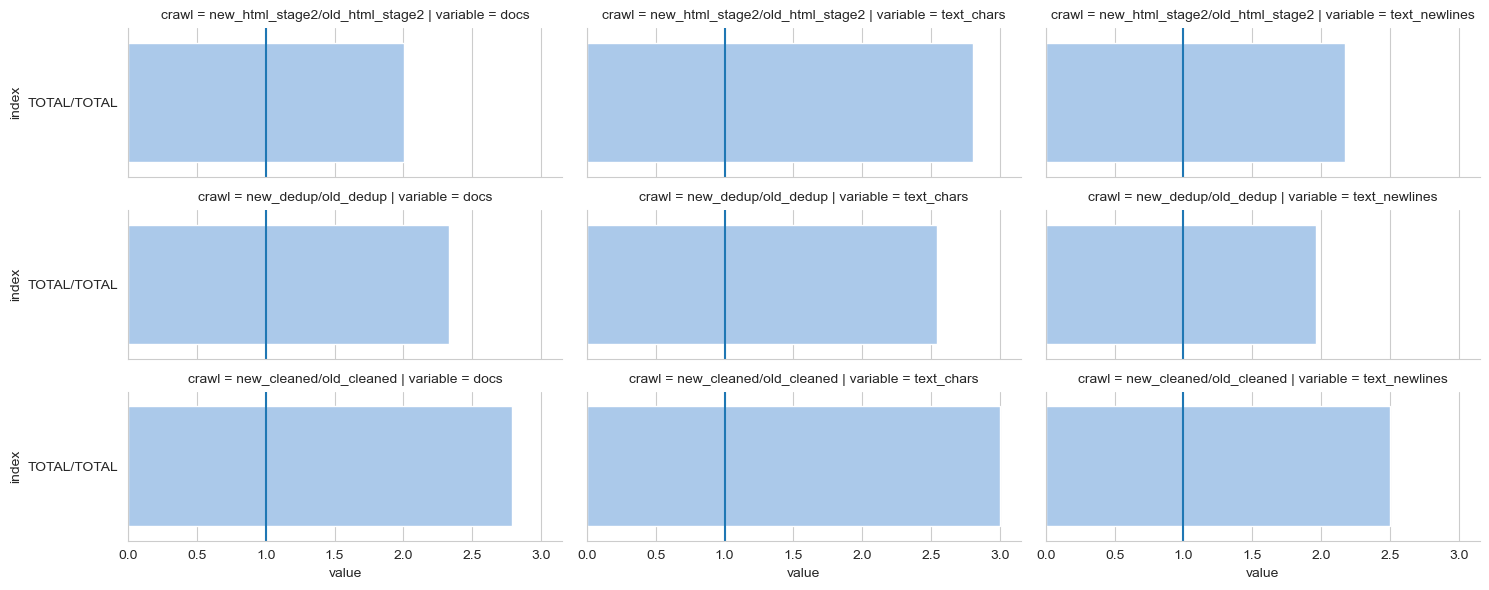

In [26]:
plots = 'new_html_stage2/old_html_stage2 new_dedup/old_dedup new_cleaned/old_cleaned'.split()
plot_ratios(pdf[(pdf.lang=='TOTAL') &
    pdf.crawl.isin(plots)], row_order=plots, 
            height=2, aspect=2.5, save_path=outdir/'ratios_totals.pdf', log_base=0)

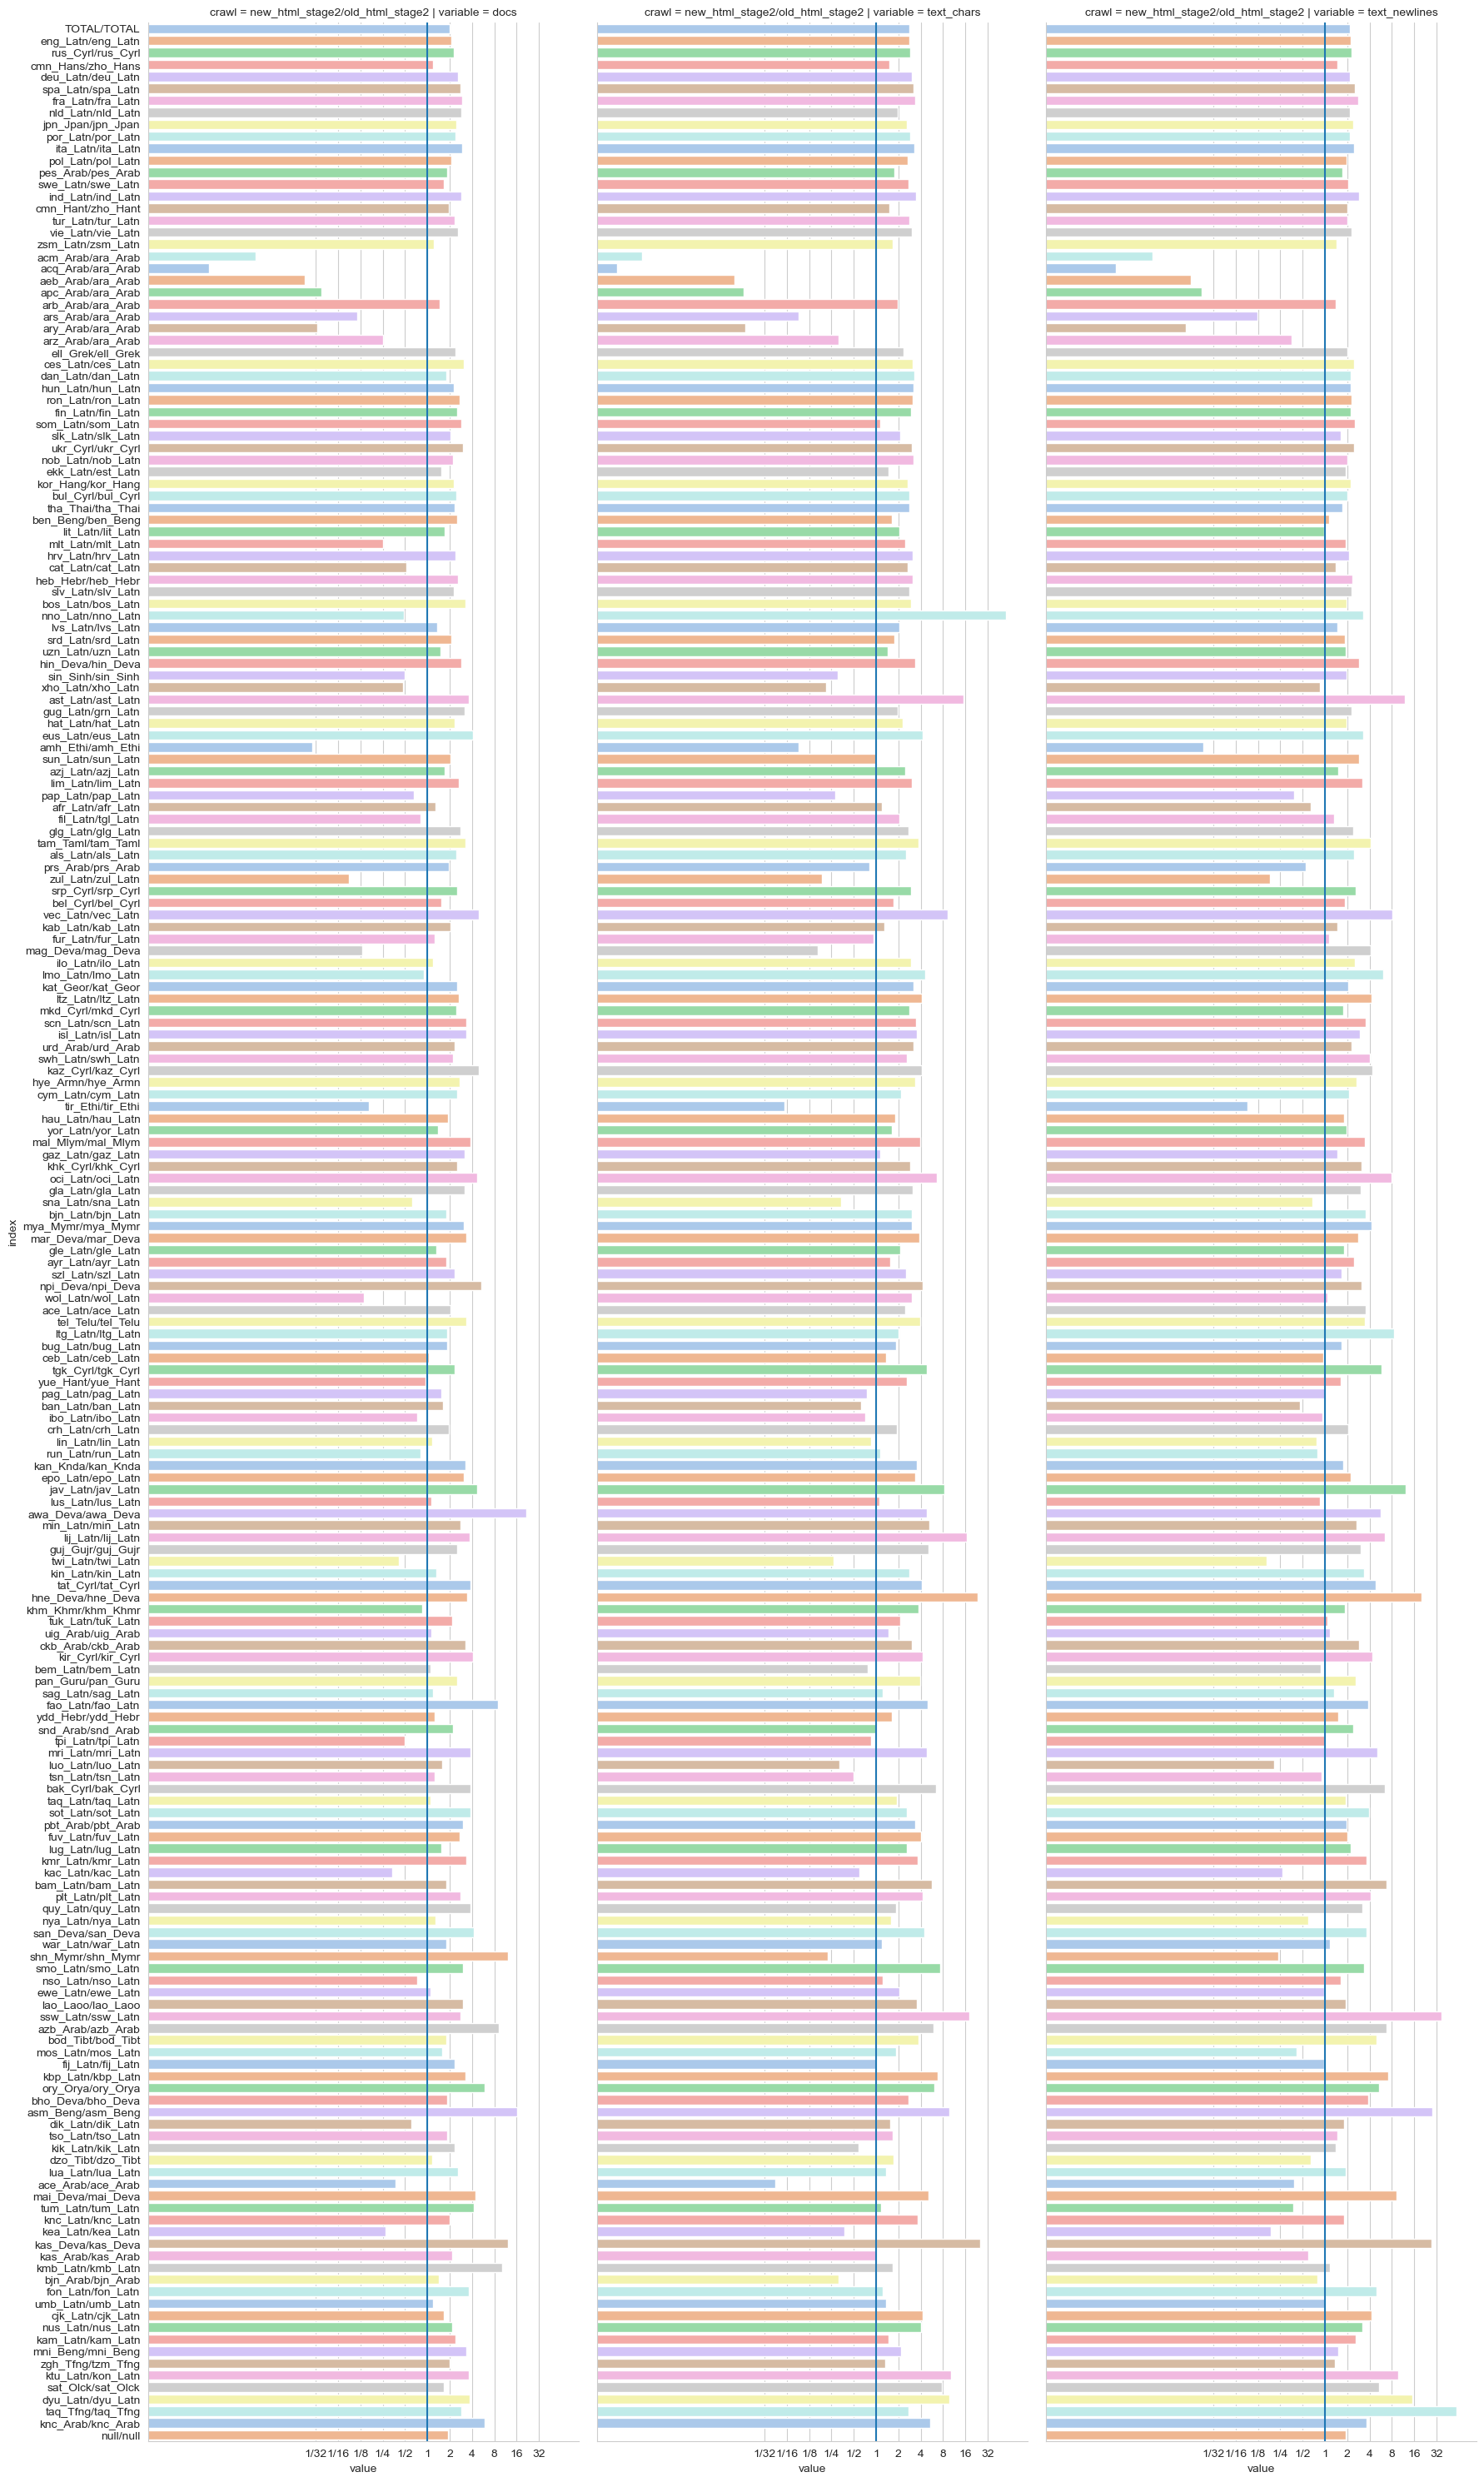

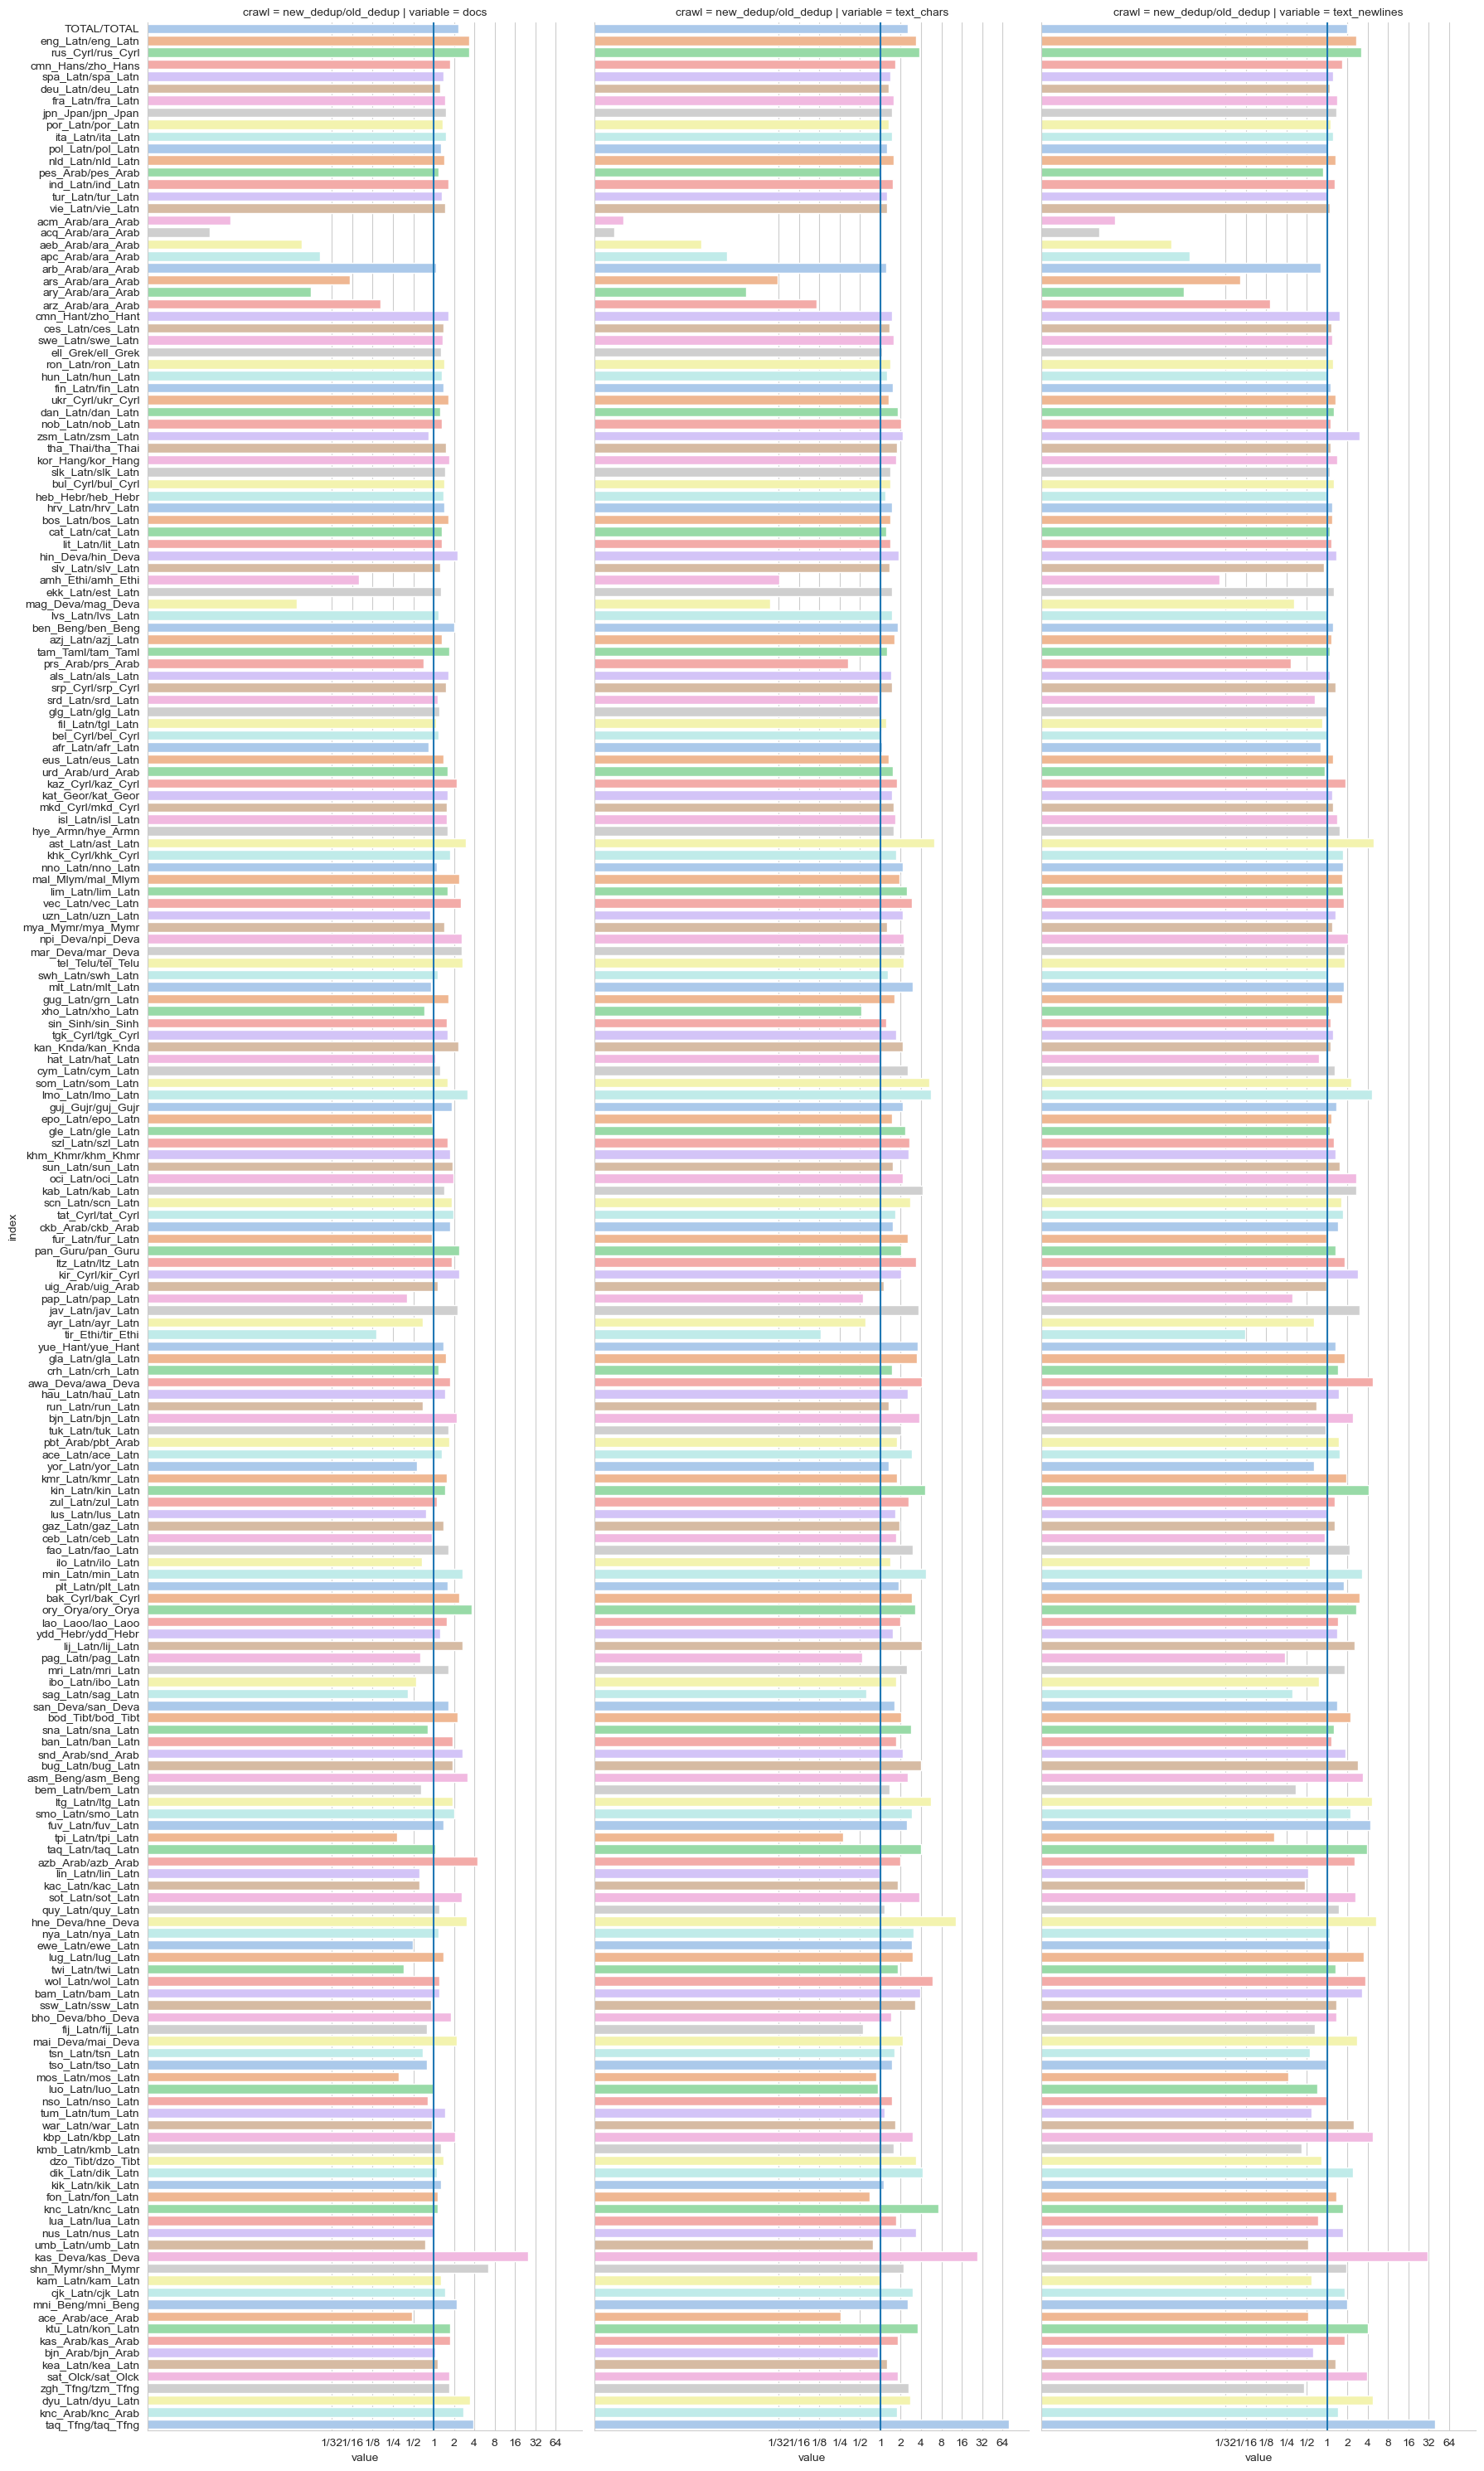

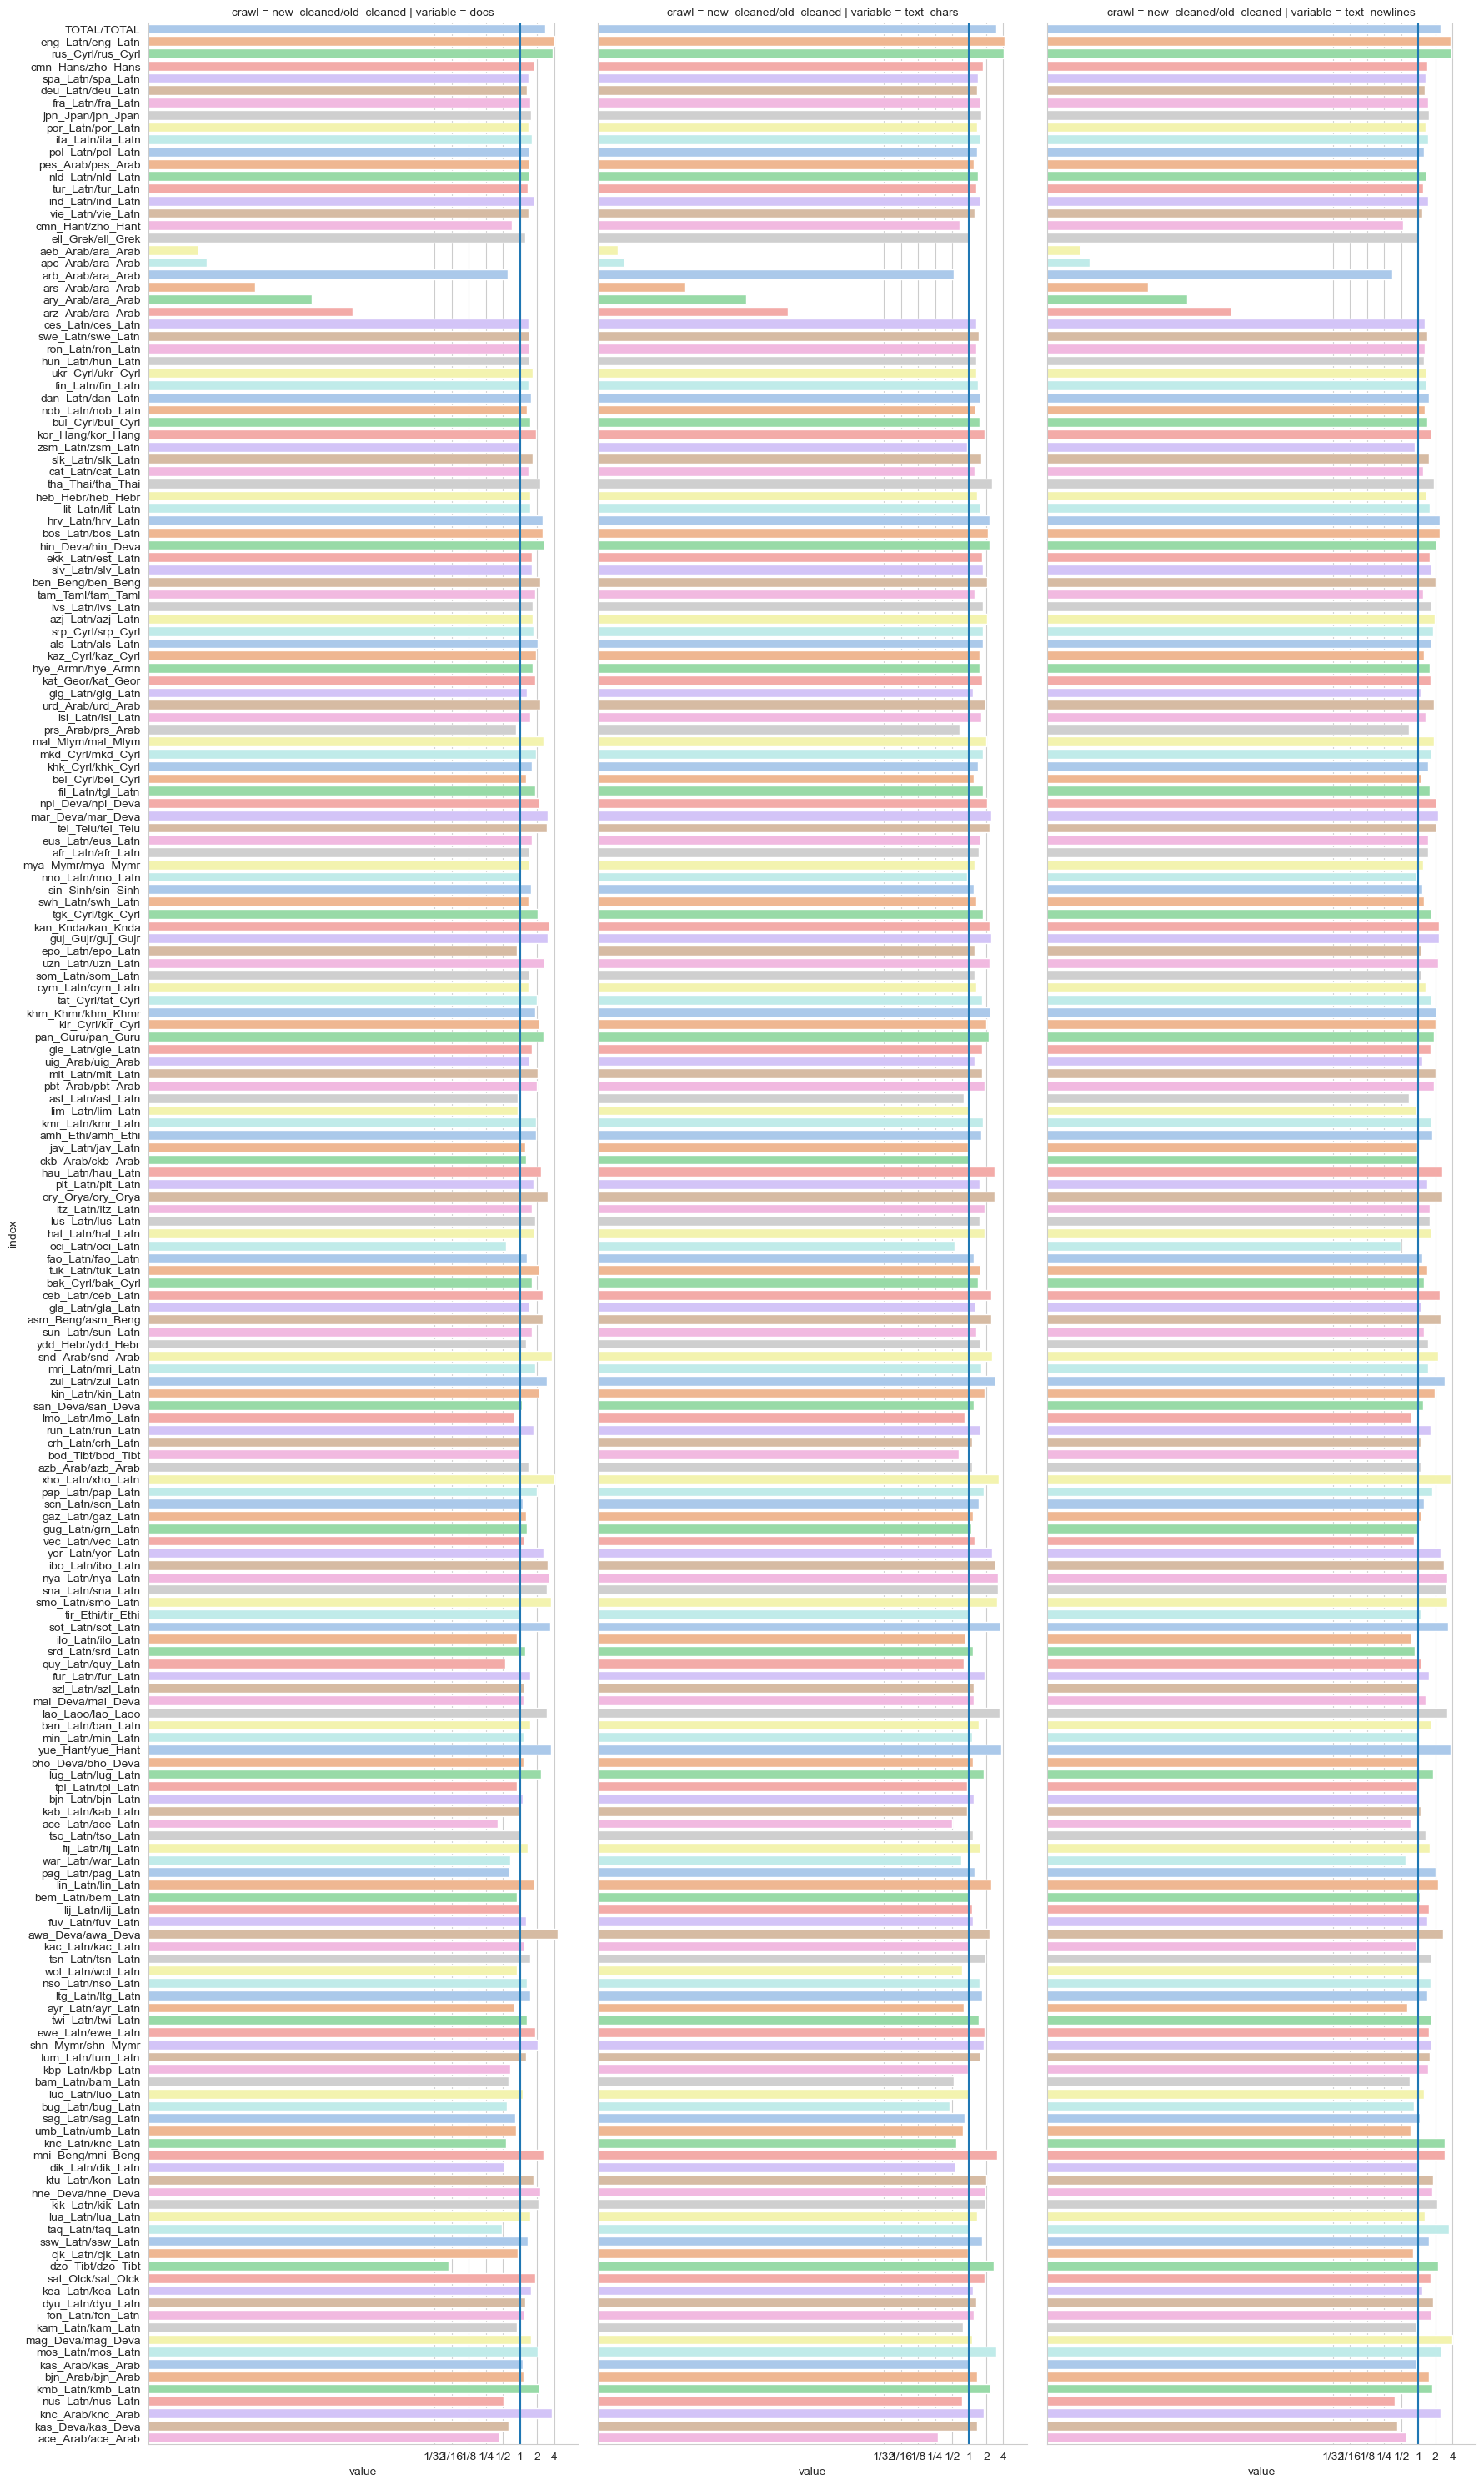

In [27]:
for p in plots:
    plot_ratios(pdf[pdf.crawl.isin([p])], height=30, aspect=0.2,
               save_path=outdir/f'ratios_{'_'.join(p.split('/')[0].split('_')[1:])}_perlang.pdf')

202 187


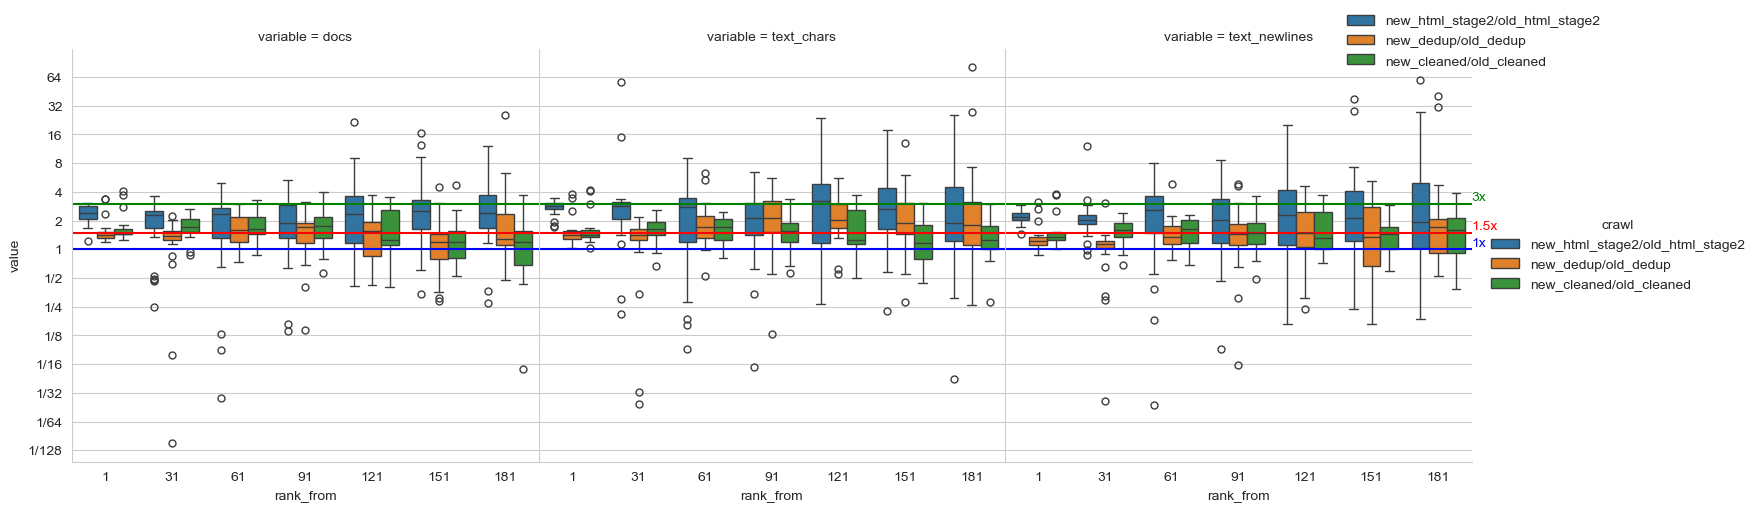

In [42]:
pdf['rank_from'] = pdf['rank'].astype(int) // 30 * 30 + 1
fpdf = pdf[pdf['index'].str.split('/').apply(lambda l: l[0]==l[1])]
print(pdf[pdf.crawl.isin(plots)]['index'].nunique(), fpdf[fpdf.crawl.isin(plots)]['index'].nunique())
plotdf = fpdf[fpdf.crawl.isin(plots)]
g = sns.catplot(data=plotdf, x='rank_from', y='value', col='variable', hue='crawl',
            hue_order=plots, 
            log_scale=True, kind='box', legend=True)
yticks=[2**i for i in range(-6,7)]
log_base = 2
b = int(np.ceil(math.log(plotdf.value.max(), log_base)))
a = int(np.floor(math.log(plotdf.value.min(), log_base)))

g.set(yticks=[log_base**i for i in range(a,b)], yticklabels=[f'1/{log_base**-i}' for i in range (a,0)] + 
                   [str(log_base**i) for i in range(0,b)] if a*b<0 else [f'${log_base}^{{{i}}}$' for i in range(a,b)])
# g.map(plt.axhline, y=1.0, color='b', linestyle='-')
for ax in g.axes.flatten():
    for y, c in zip([1,1.5,3],'b r g'.split()):
        ax.axhline(y, color=c)
         # Add text above the line
        ax.text(
            x=ax.get_xlim()[1],  # Right side of the plot
            y=y,         # Line's y-coordinate
            s=f'{y}x',  # Formatted value
            verticalalignment='bottom',  # Position text above the line
            horizontalalignment='left',
            color=c
        )
g.fig.legend(
    loc='center right',  # Inside plot location
    bbox_to_anchor=(0.92, 0.95),  # Fine-tune position
    # title='Legend Title',
    frameon=False,  # Add background
    fancybox=True,  # Rounded corners
    shadow=True    # Add shadow
)
g.figure.subplots_adjust(wspace=0, hspace=0)
plt.show()

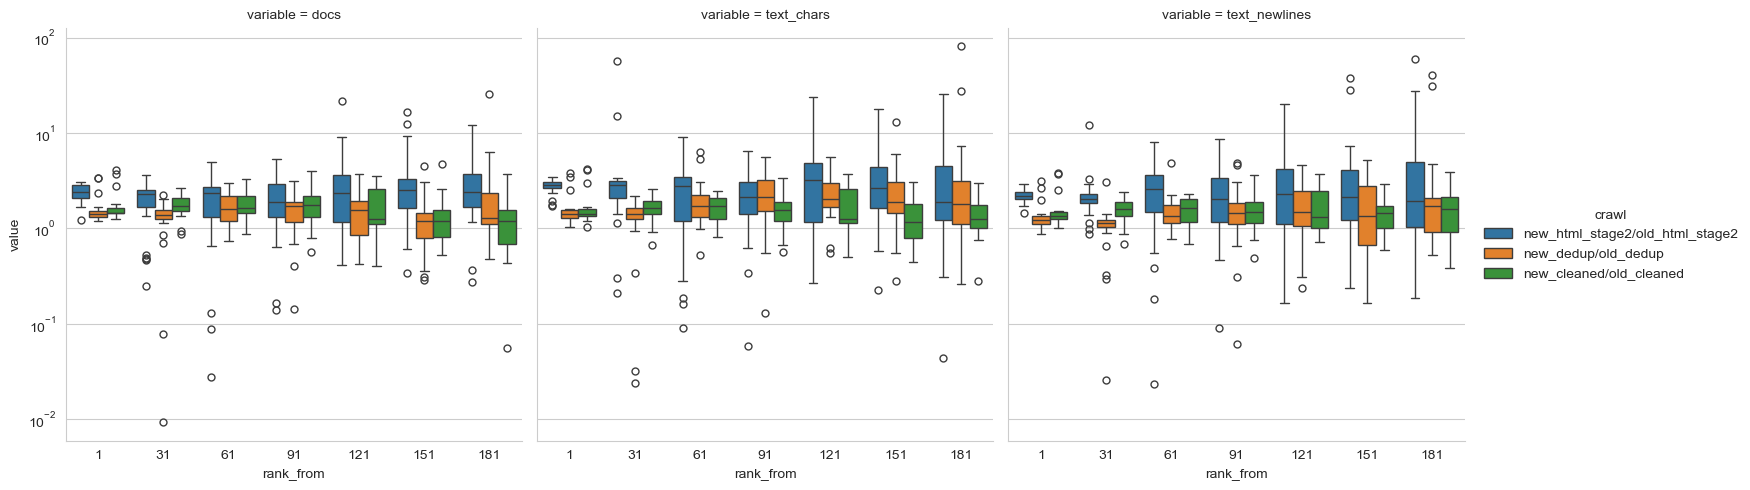

In [29]:
sns.catplot(data=fpdf[fpdf.crawl.isin(plots)], x='rank_from', y='value', col='variable', hue='crawl',
            hue_order=plots, 
            log_scale=True, kind='box')

# Ratios between steps

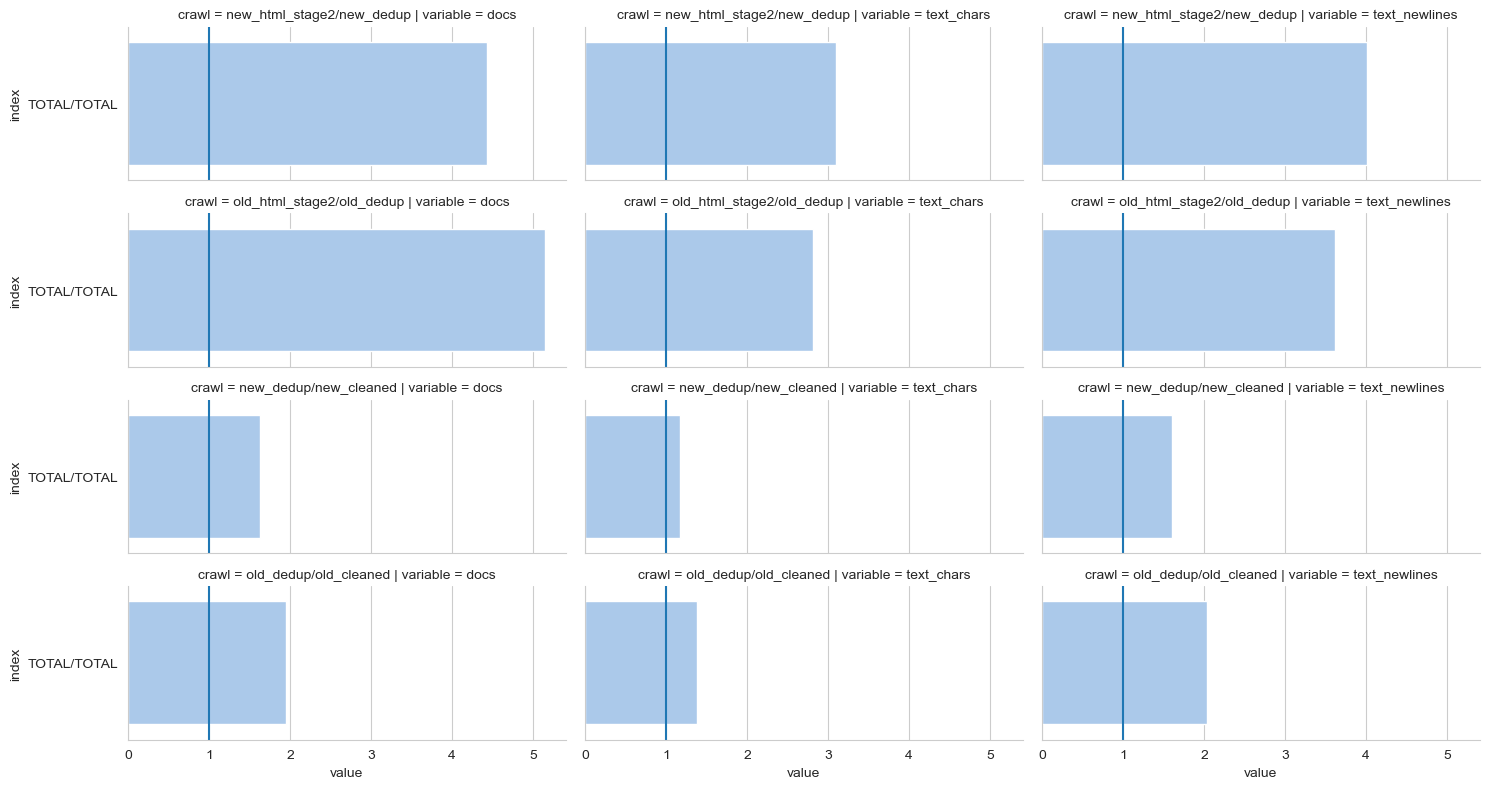

In [47]:
plots = 'new_html_stage2/new_dedup old_html_stage2/old_dedup new_dedup/new_cleaned old_dedup/old_cleaned'.split()
plot_ratios(pdf[(pdf.lang=='TOTAL') &
    pdf.crawl.isin(plots)], row_order=plots, 
            height=2, aspect=2.5, save_path=outdir/'ratios_steps_totals.pdf', log_base=0)

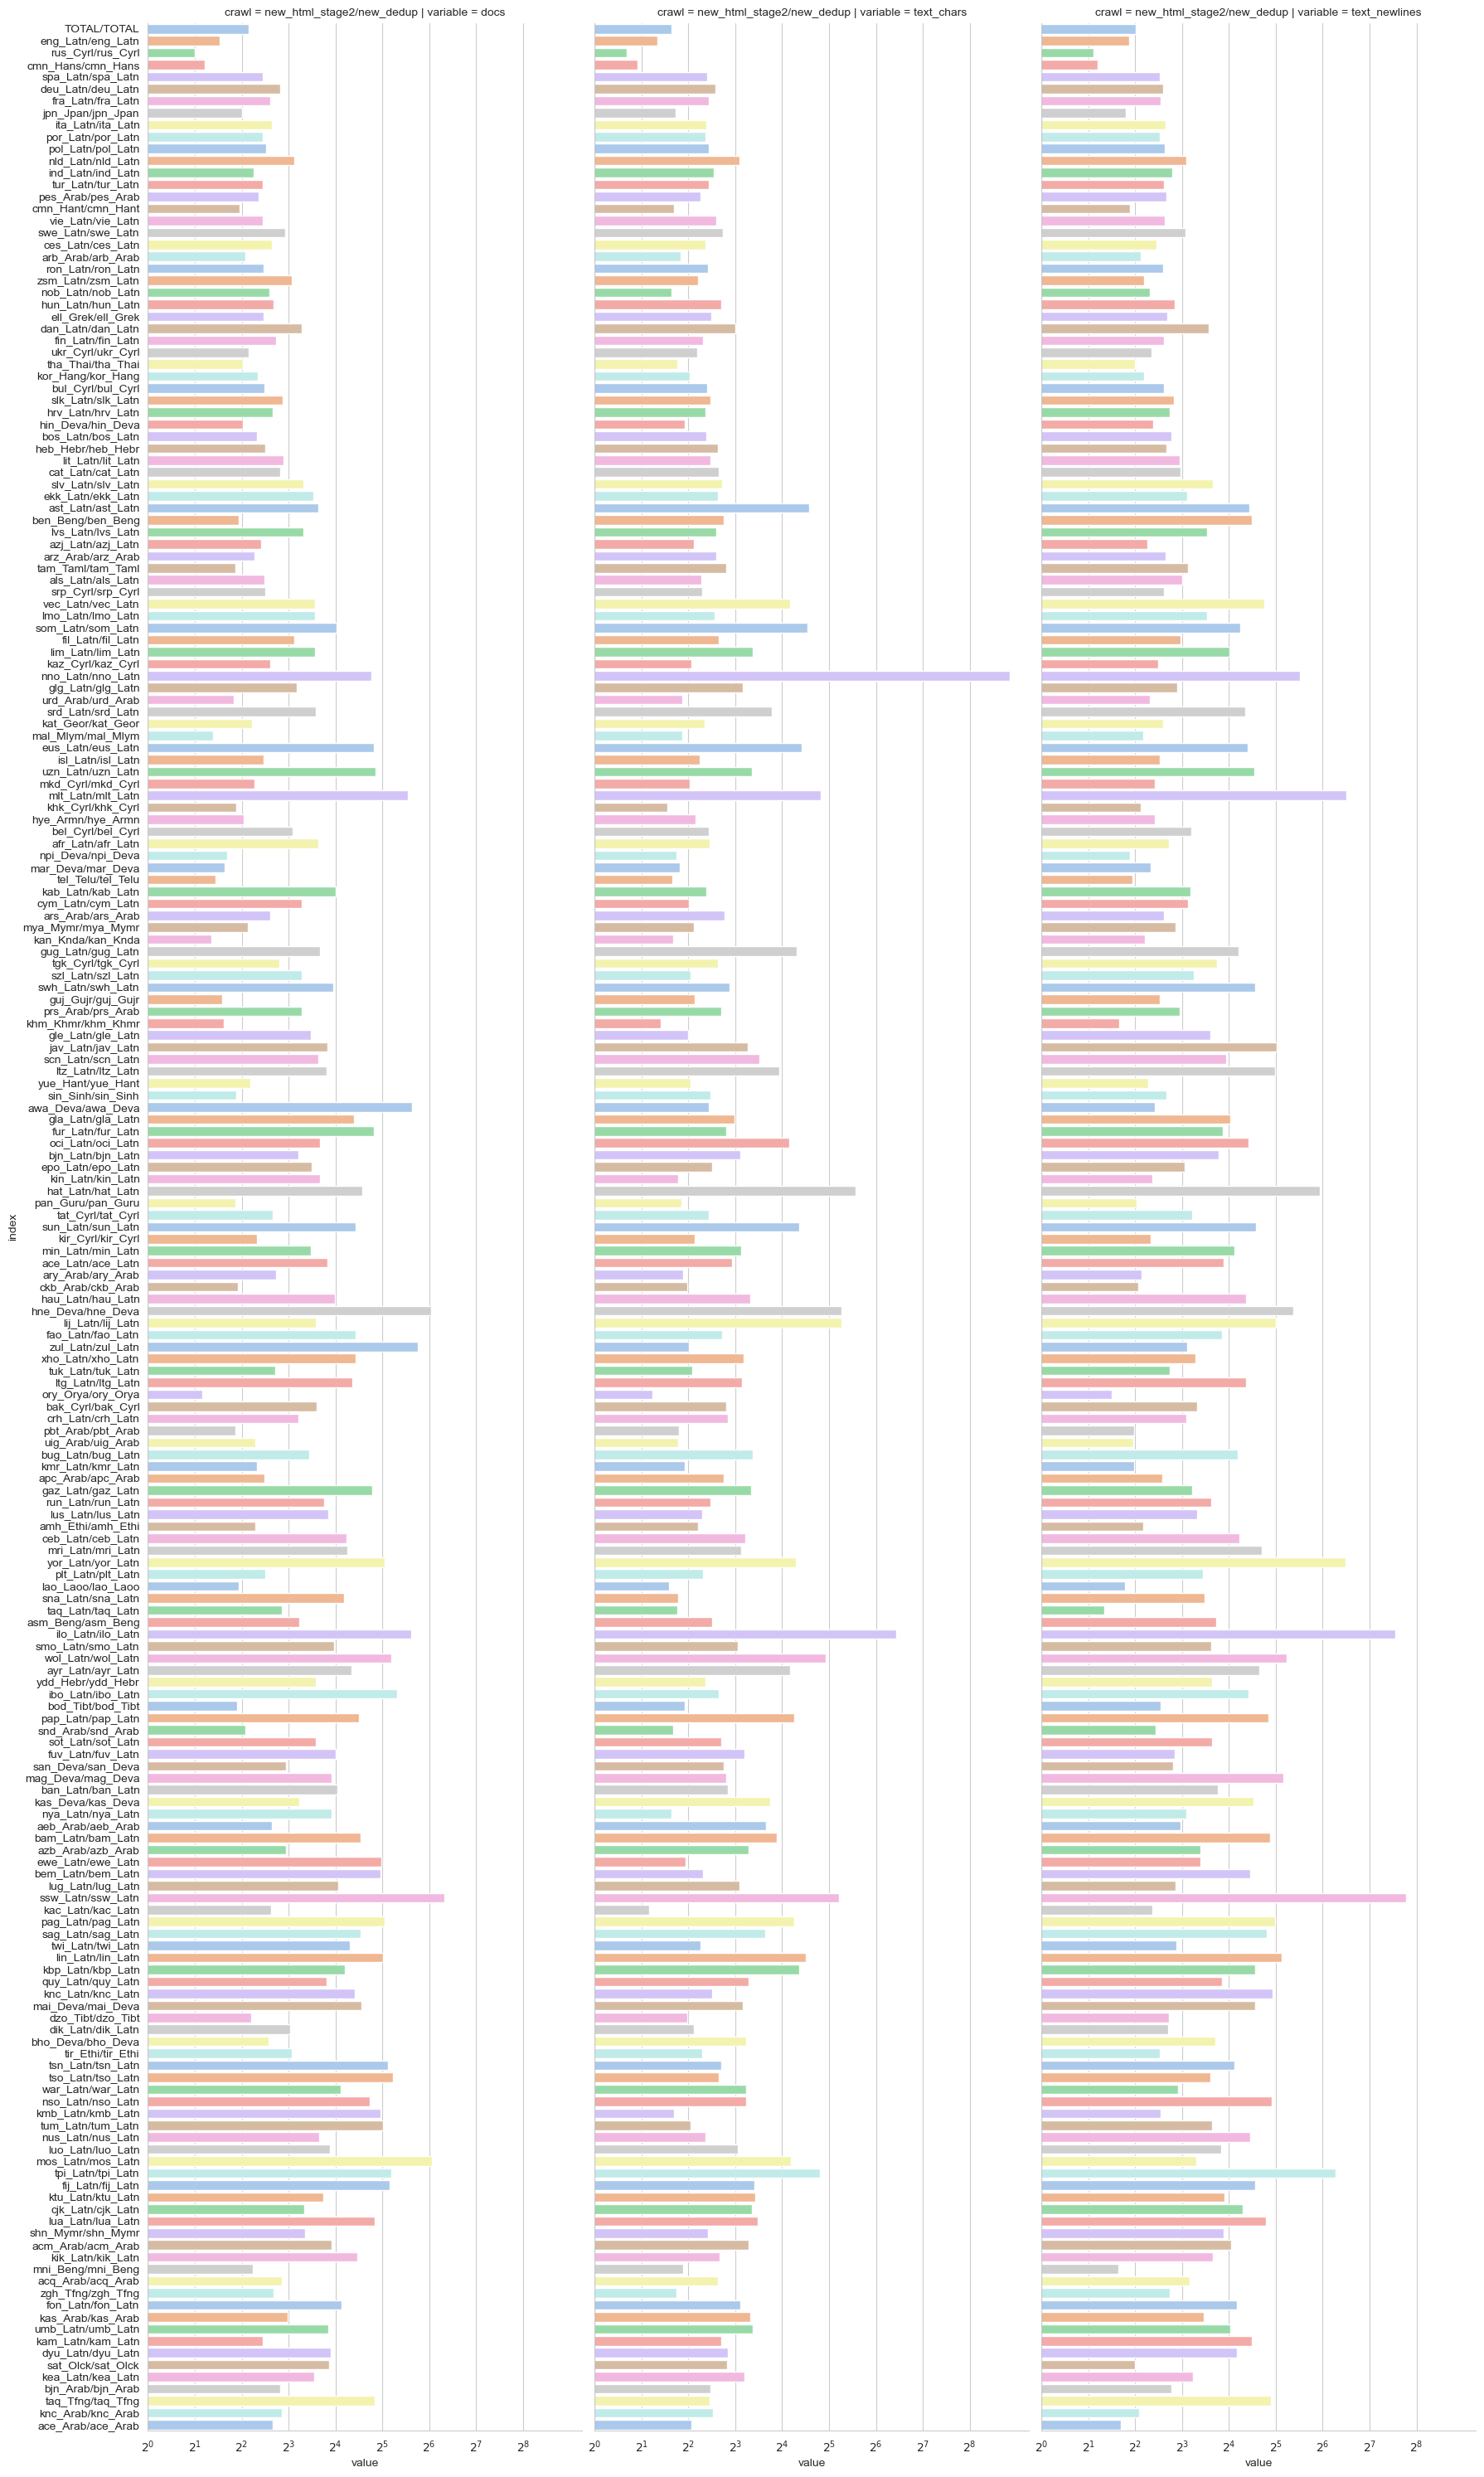

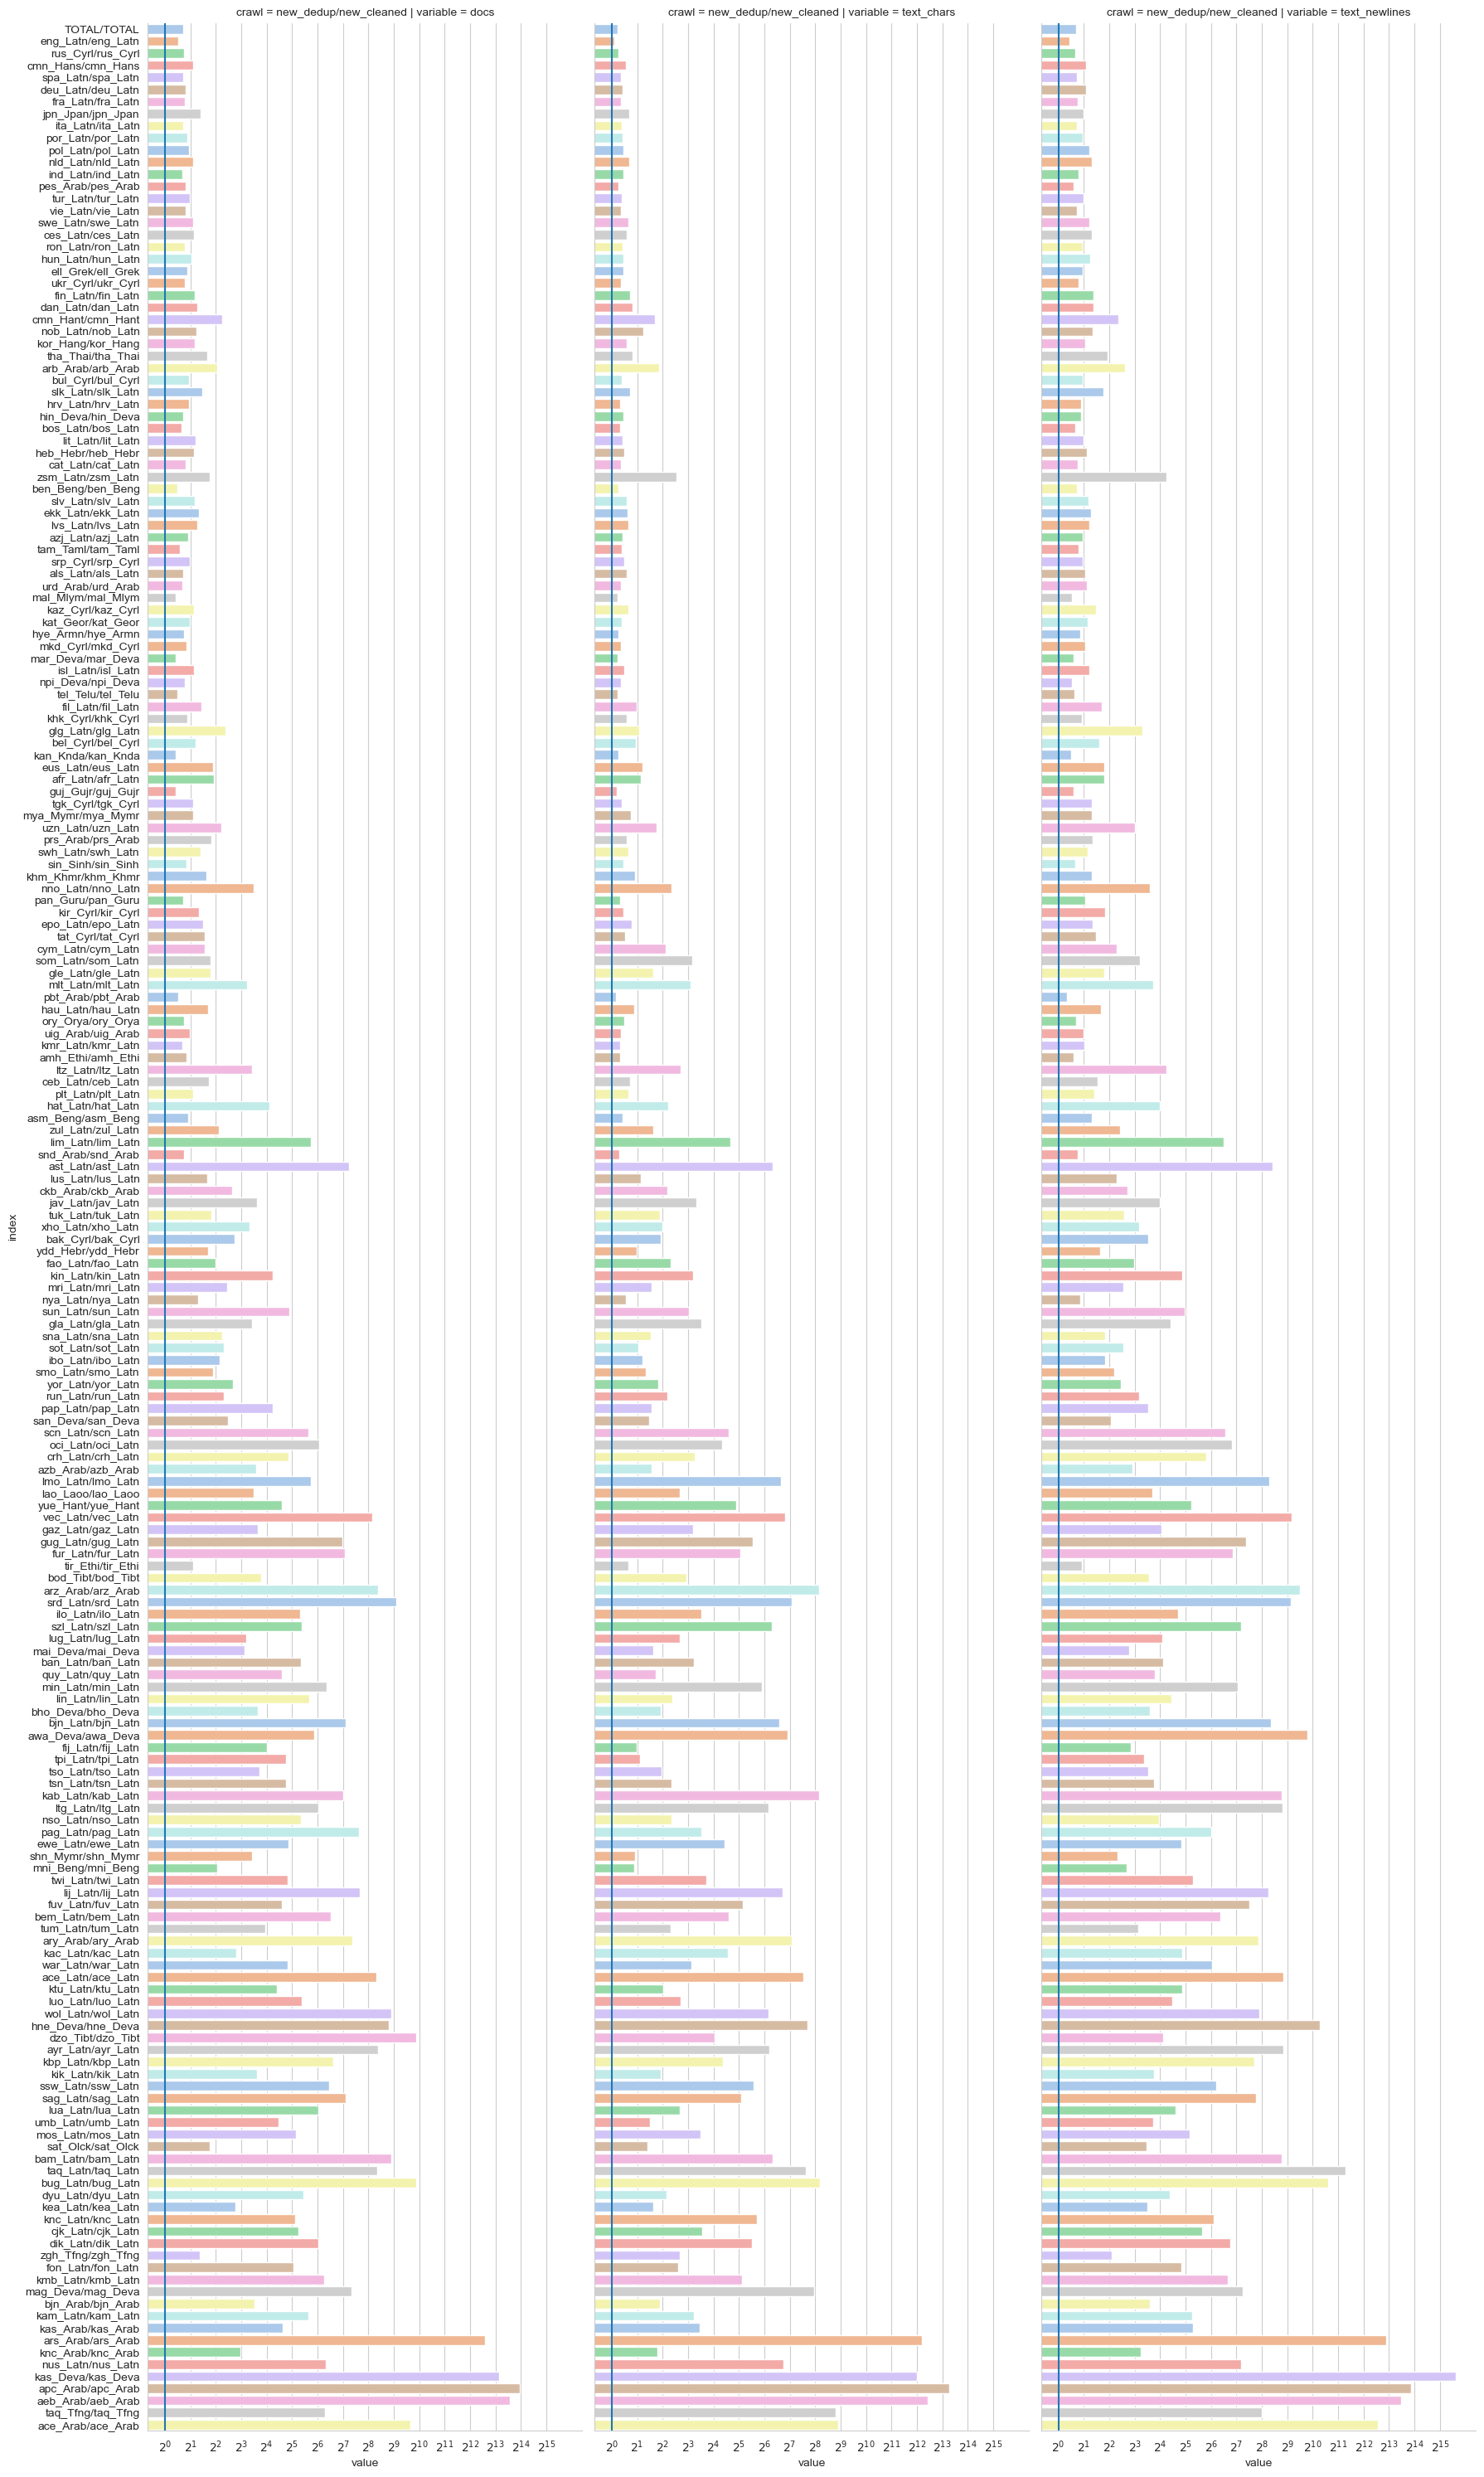

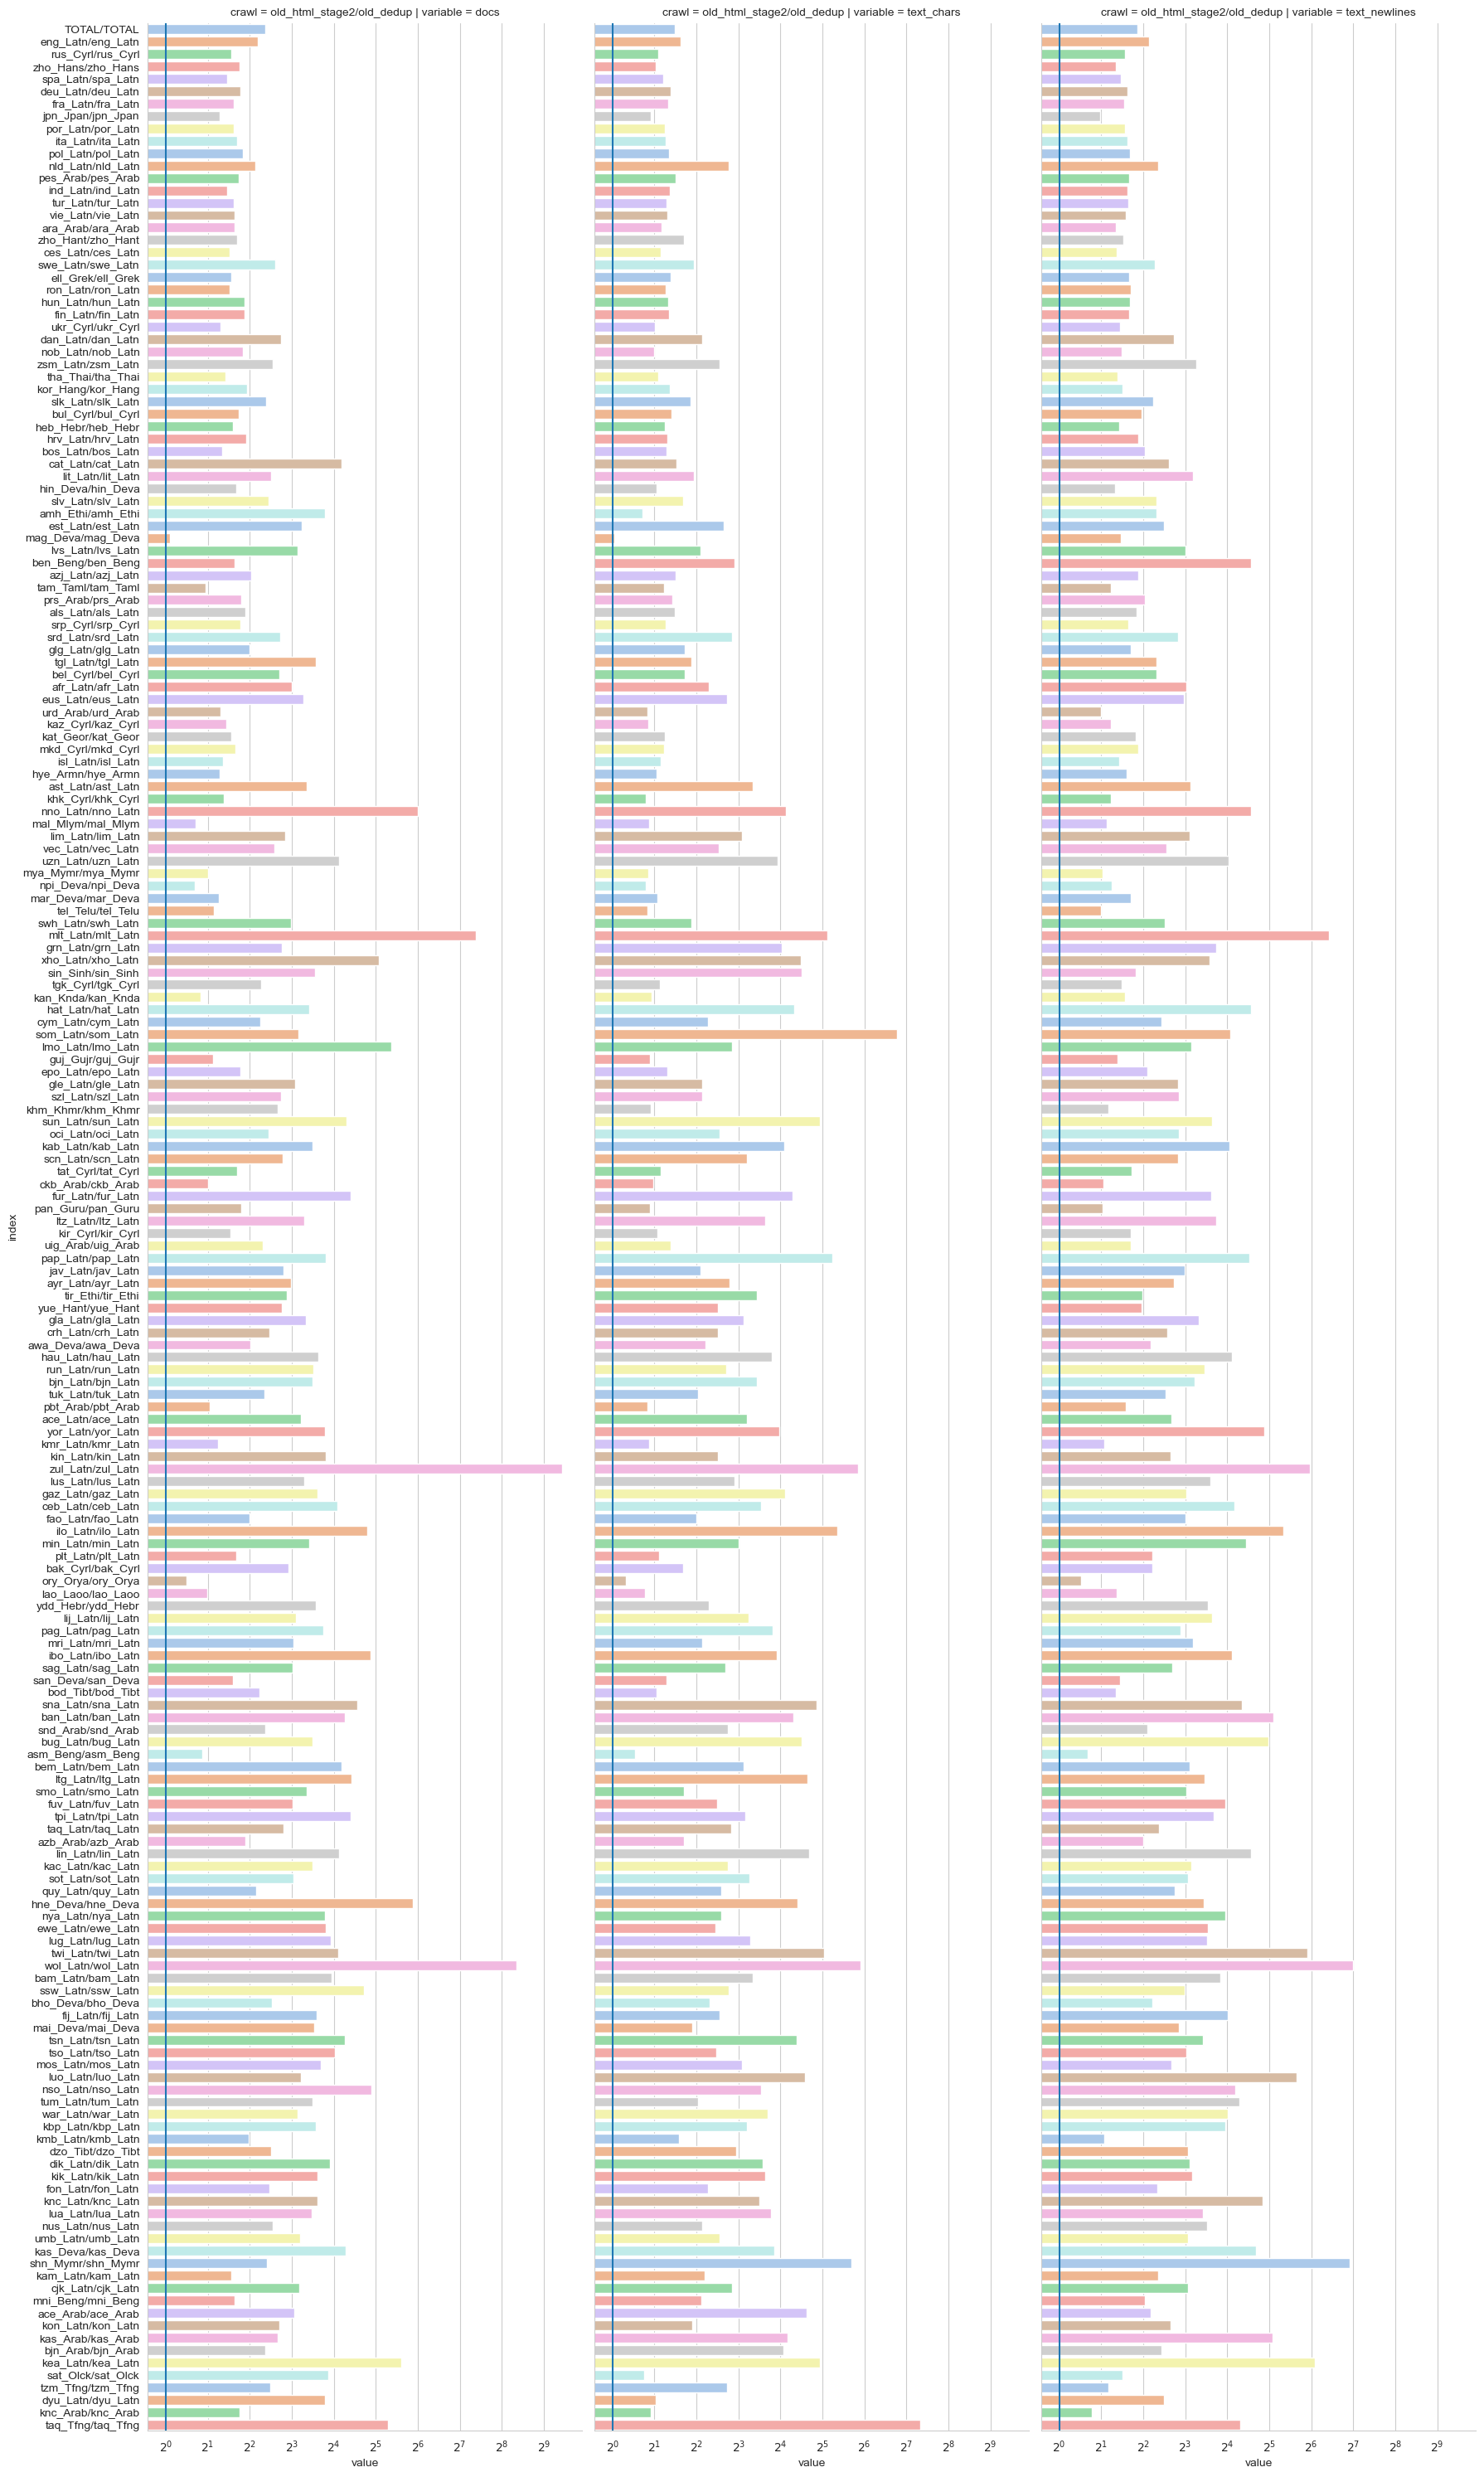

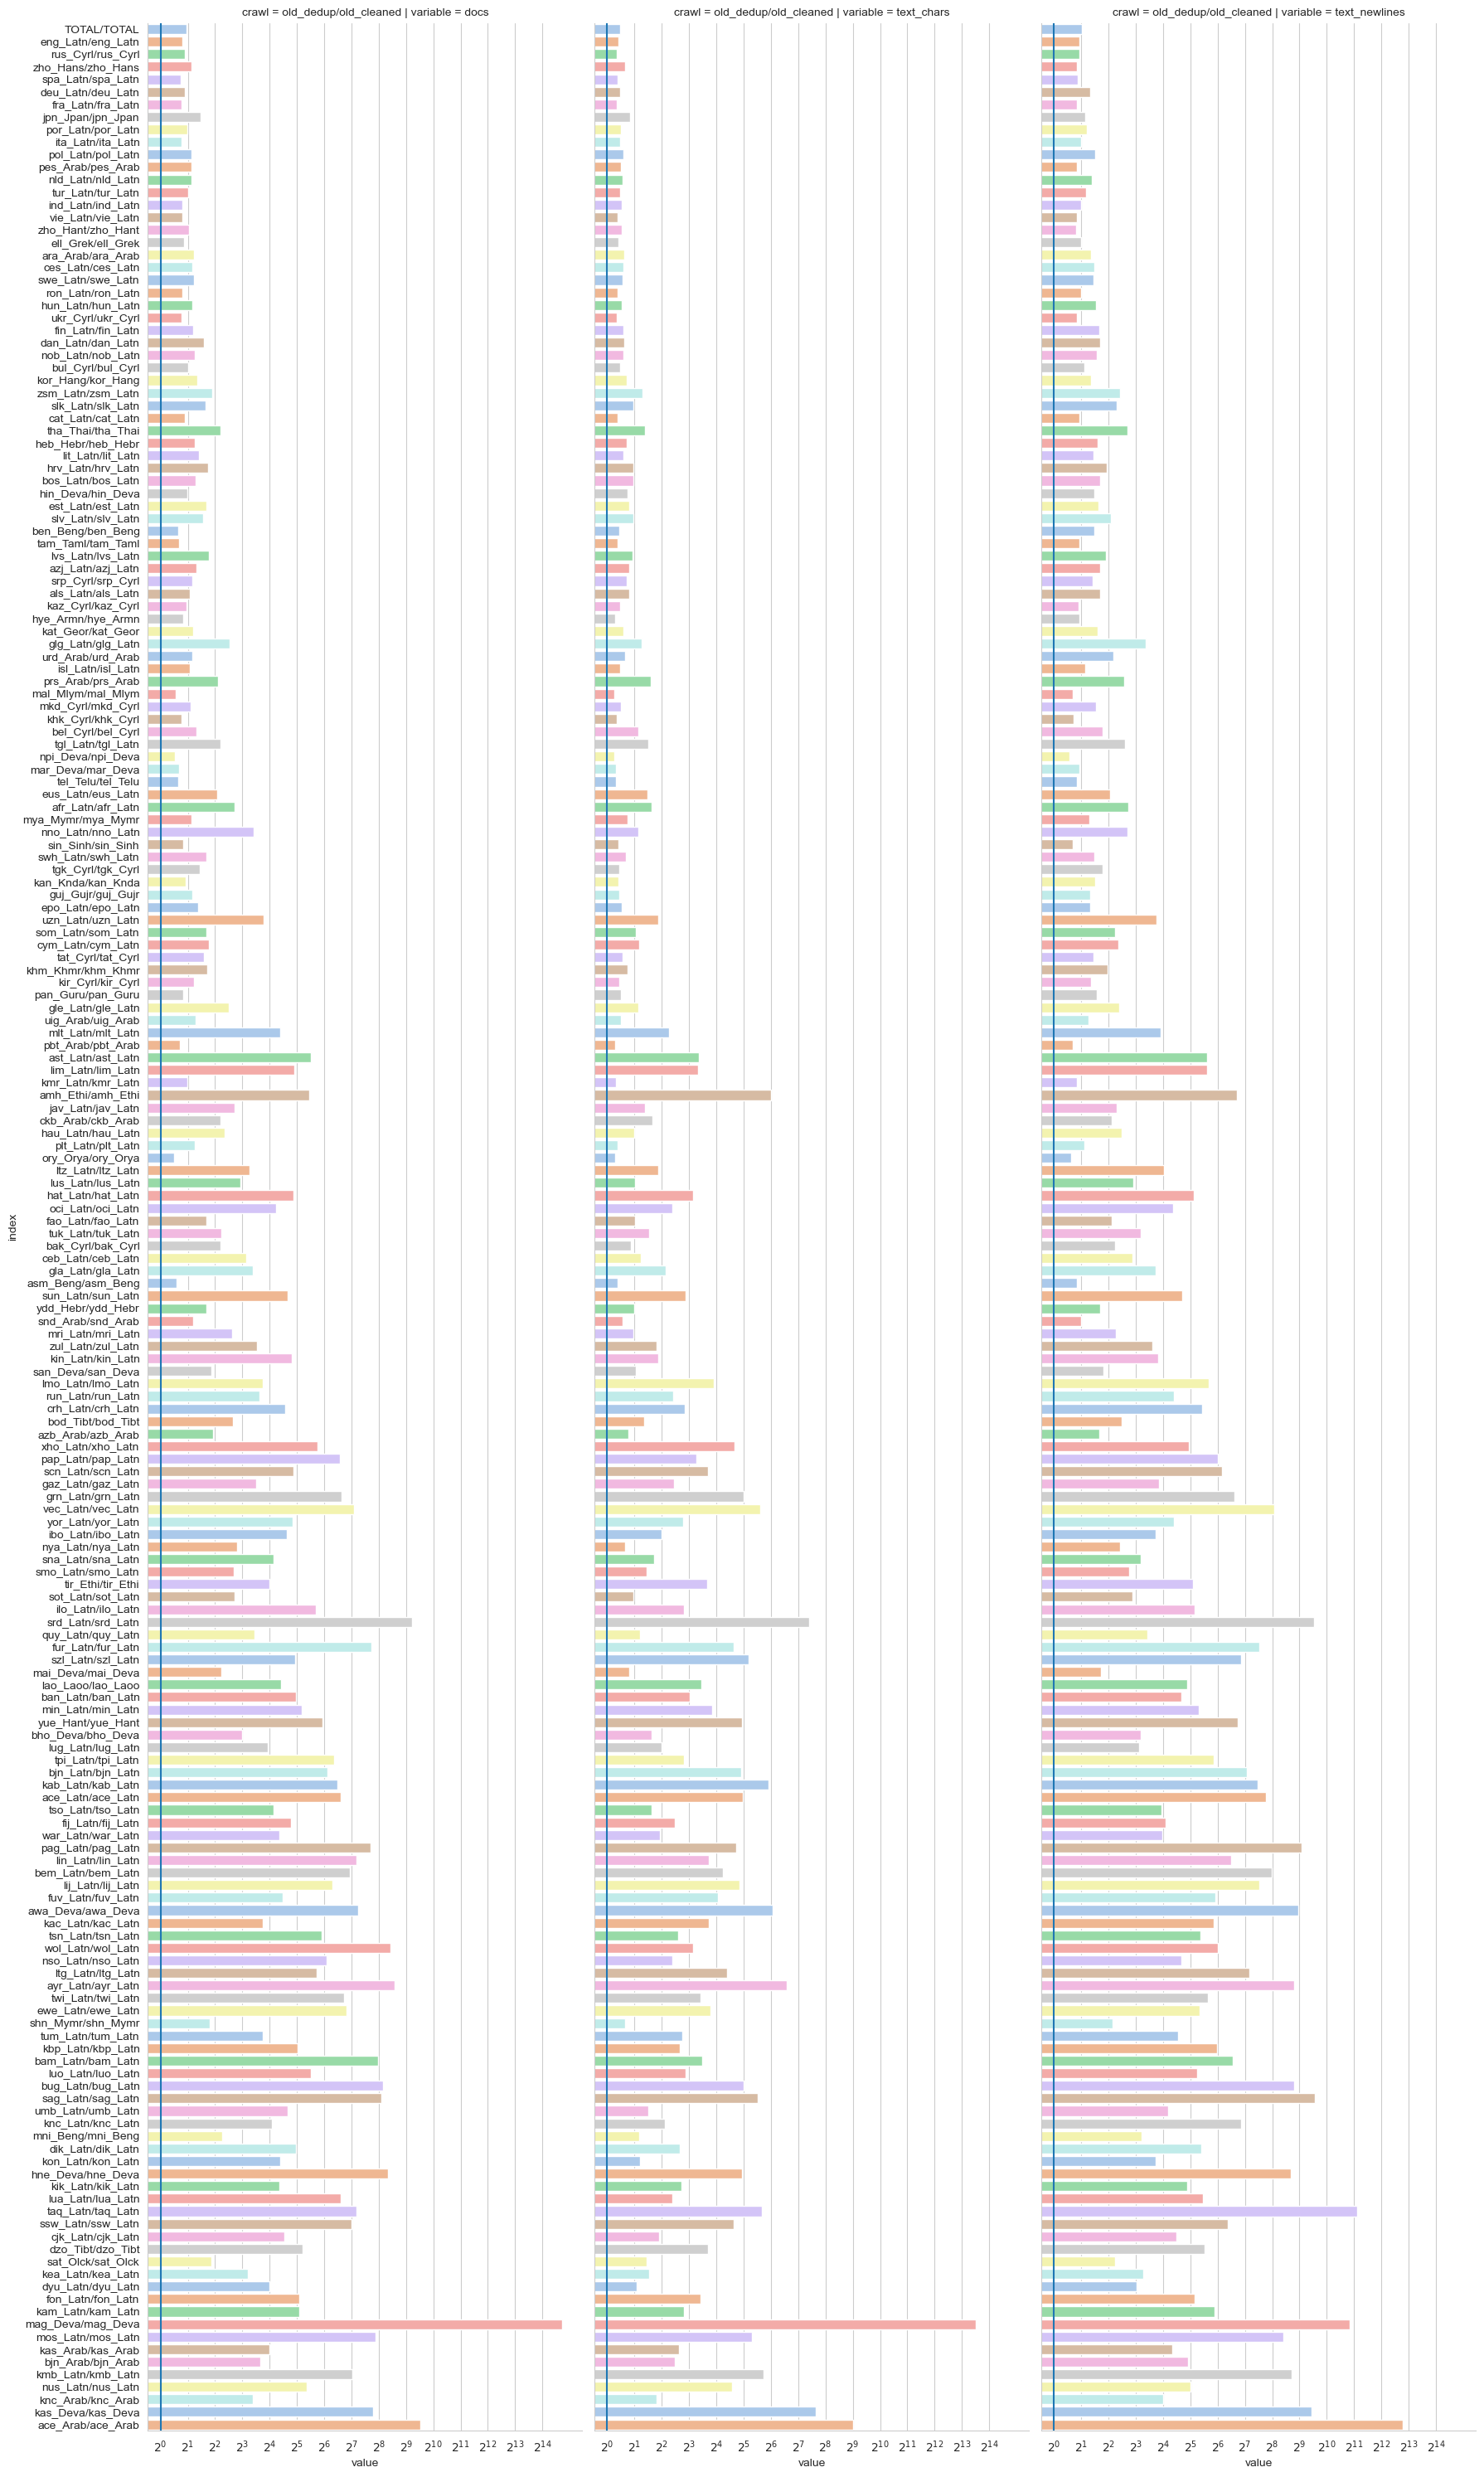

In [44]:
for p in plots:
    plot_ratios(pdf[pdf.crawl.isin([p])], height=30, aspect=0.2,
               save_path=outdir/f'ratios_steps_{p.replace('/', 'VS')}_perlang.pdf')

In [45]:
plots

['new_html_stage2/new_dedup',
 'new_dedup/new_cleaned',
 'old_html_stage2/old_dedup',
 'old_dedup/old_cleaned']

209 209


/var/folders/mw/3x2qsh0s2yb5krjrx4yh7drh0000gn/T/ipykernel_2638/447124754.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotdf['version'], plotdf['step'] = plotdf.crawl.str.split('_').str[0], plotdf.crawl.str.split('_').str[-1]
/var/folders/mw/3x2qsh0s2yb5krjrx4yh7drh0000gn/T/ipykernel_2638/447124754.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotdf['version'], plotdf['step'] = plotdf.crawl.str.split('_').str[0], plotdf.crawl.str.split('_').str[-1]
/var/folders/mw/3x2qsh0s2yb5krjrx4yh7drh0000

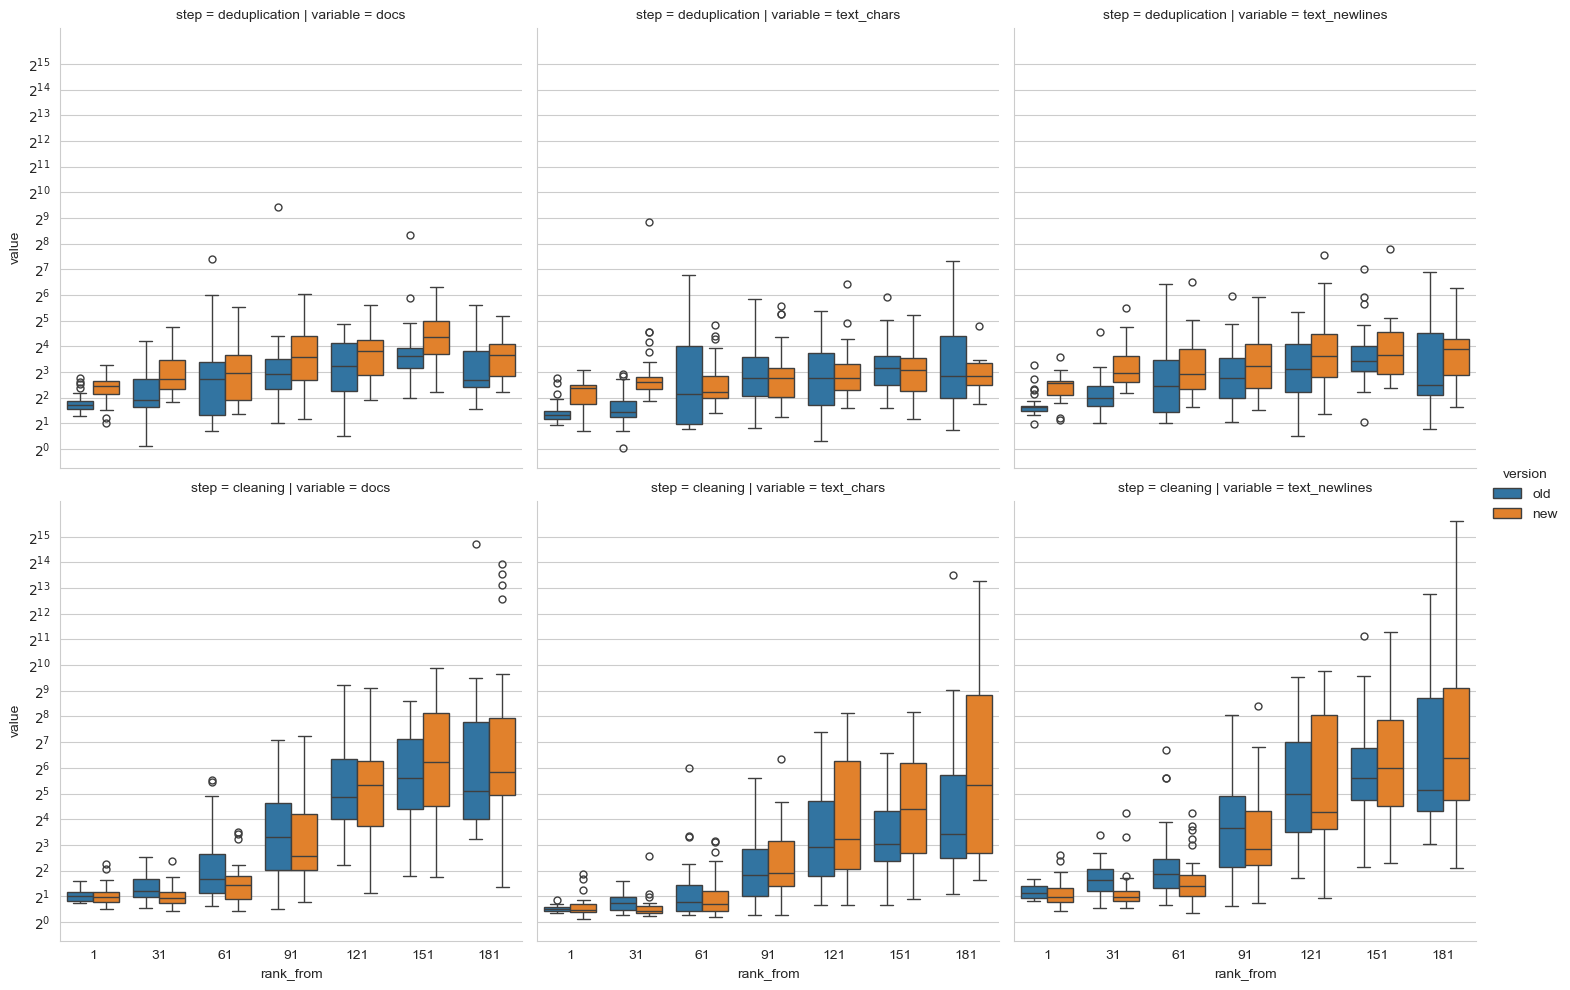

In [55]:
pdf['rank_from'] = pdf['rank'].astype(int) // 30 * 30 + 1
fpdf = pdf[pdf['index'].str.split('/').apply(lambda l: l[0]==l[1])]
print(pdf[pdf.crawl.isin(plots)]['index'].nunique(), fpdf[fpdf.crawl.isin(plots)]['index'].nunique())
plotdf = fpdf[fpdf.crawl.isin(plots)]
plotdf['version'], plotdf['step'] = plotdf.crawl.str.split('_').str[0], plotdf.crawl.str.split('_').str[-1]
plotdf.step = plotdf.step.replace({'cleaned':'cleaning', 'dedup':'deduplication'})
g = sns.catplot(data=plotdf, x='rank_from', y='value', col='variable', hue='version',row='step',
            row_order='deduplication cleaning'.split(), 
            log_scale=True, kind='box', legend=True)
yticks=[2**i for i in range(-6,7)]
log_base = 2
b = int(np.ceil(math.log(plotdf.value.max(), log_base)))
a = int(np.floor(math.log(plotdf.value.min(), log_base)))

g.set(yticks=[log_base**i for i in range(a,b)], yticklabels=[f'1/{log_base**-i}' for i in range (a,0)] + 
                   [str(log_base**i) for i in range(0,b)] if a*b<0 else [f'${log_base}^{{{i}}}$' for i in range(a,b)])
# g.map(plt.axhline, y=1.0, color='b', linestyle='-')
# for ax in g.axes.flatten():
#     for y, c in zip([1,1.5,3],'b r g'.split()):
#         ax.axhline(y, color=c)
#          # Add text above the line
#         ax.text(
#             x=ax.get_xlim()[1],  # Right side of the plot
#             y=y,         # Line's y-coordinate
#             s=f'{y}x',  # Formatted value
#             verticalalignment='bottom',  # Position text above the line
#             horizontalalignment='left',
#             color=c
#         )
# g.fig.legend(
#     loc='center right',  # Inside plot location
#     bbox_to_anchor=(0.92, 0.95),  # Fine-tune position
#     # title='Legend Title',
#     frameon=False,  # Add background
#     fancybox=True,  # Rounded corners
#     shadow=True    # Add shadow
# )
# g.figure.subplots_adjust(wspace=0, hspace=0)
plt.show()

# Sanity checks

In [129]:
pdf[pdf.crawl=='2.0_annotated/1.2_cleaned'].query('index=="azb_Arab/az"')

index      lang                      crawl       variable  \
232   azb_Arab/az  azb_Arab  2.0_annotated/1.2_cleaned  text_newlines   
840   azb_Arab/az  azb_Arab  2.0_annotated/1.2_cleaned     text_chars   
1448  azb_Arab/az  azb_Arab  2.0_annotated/1.2_cleaned           docs   

         value  
232   0.054452  
840   0.052207  
1448  0.230904

In [128]:
1/16

0.0625

# Compare extracted docs, chars per crawl